# Preprocessing

In this notebook we document a few preprocessing steps which are not covered by the main preprocessing notebooks in `experiments/v/`. These steps include dimensionality reduction and feature engineering for models which can not handle high-dimensional data.(e.g. ARIMAX, HARX, etc.), more specifically:
- Dimensionality reduction using PCA. PCs are not saved as features, but used inside models, as standardization depends on training set. Since retraining dates are not fixed, leaving computation of PCs to the model is more flexible.
- Computing mean value of ob features in hourly windows,
- Computing trend of ob features over time in hourly windows,
- Compute trade volume in hourly windows,

Mean, trend and volume are saved as features.

At the end of notebook we compute a template file to be populated when testing different models. 

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime

sns.set(style="whitegrid")

import os
import sys
from pathlib import Path
from zipfile import ZipFile

PROJ_ROOT = Path(os.getcwd()).parent.parent
sys.path.append(str(PROJ_ROOT))  # add project root file to the python paths

In [4]:
data_path = PROJ_ROOT / "data"
raw_data_path = data_path / "raw"

# Dimensionality Reduction and Feature Engineering 

Here we document the preprocessing steps used inside each of the simple multivariate models, such as ARIMX, GARCHX, HARX, etc, which are models linear in OB features. Unlike neural networks, these models do not have ability to perform automatic feature engineering. 


## PCA

In [4]:
feature_names = [
    "bid_volume",
    "ask_volume",
    "bid_depth",
    "ask_depth",
    "depth_diff",
    "spread",
    "volume_diff",
    "bid_slope",
    "ask_slope",
    "weighted_spread",
]

In [5]:
first_test_time = datetime.strptime("2018-07-01 00:00:00", "%Y-%m-%d %H:%M:%S")

In [6]:
vis_data = (
    pl.read_csv(data_path / "btc" / "data_df.csv")
    .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
    .sort("datetime")
)
vis_data

shape: (2_579, 1_215)
┌───────────┬──────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ datetime  ┆ vol      ┆ ret       ┆ ret_t-1   ┆ … ┆ volume_di ┆ weighted_ ┆ ask_slope ┆ bid_slope │
│ ---       ┆ ---      ┆ ---       ┆ ---       ┆   ┆ ff_t-120  ┆ spread_t- ┆ _t-120    ┆ _t-120    │
│ datetime[ ┆ f64      ┆ f64       ┆ f64       ┆   ┆ ---       ┆ 120       ┆ ---       ┆ ---       │
│ μs]       ┆          ┆           ┆           ┆   ┆ f64       ┆ ---       ┆ f64       ┆ f64       │
│           ┆          ┆           ┆           ┆   ┆           ┆ f64       ┆           ┆           │
╞═══════════╪══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2018-06-0 ┆ 0.000143 ┆ -0.002229 ┆ -0.000807 ┆ … ┆ -10440.51 ┆ 1036.7256 ┆ 7548.68   ┆ 6997.83   │
│ 4         ┆          ┆           ┆           ┆   ┆ 621       ┆ 48        ┆           ┆           │
│ 23:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2018-06-0 ┆ 0.000115 ┆ 0.001552  ┆ -0.000217 ┆ … ┆ -10336.34 ┆ 1031.8000 ┆ 7539.55   ┆ 6937.0    │
│ 5         ┆          ┆           ┆           ┆   ┆ 9463      ┆ 62        ┆           ┆           │
│ 00:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2018-06-0 ┆ 0.00009  ┆ -0.001719 ┆ 0.001004  ┆ … ┆ -10441.48 ┆ 1055.5384 ┆ 7531.36   ┆ 6981.42   │
│ 5         ┆          ┆           ┆           ┆   ┆ 4297      ┆ 87        ┆           ┆           │
│ 01:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2018-06-0 ┆ 0.000502 ┆ -0.010899 ┆ 0.000669  ┆ … ┆ -10375.84 ┆ 1043.1412 ┆ 7520.68   ┆ 6964.01   │
│ 5         ┆          ┆           ┆           ┆   ┆ 6459      ┆ 15        ┆           ┆           │
│ 02:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2018-06-0 ┆ 0.000146 ┆ 0.000408  ┆ 0.000473  ┆ … ┆ -10304.46 ┆ 1032.4915 ┆ 7486.98   ┆ 6860.46   │
│ 5         ┆          ┆           ┆           ┆   ┆ 9895      ┆ 35        ┆           ┆           │
│ 03:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ …         ┆ …        ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2018-09-3 ┆ 0.000025 ┆ -0.000451 ┆ -0.00086  ┆ … ┆ -9282.363 ┆ 1051.1443 ┆ 6629.0    ┆ 6060.0    │
│ 0         ┆          ┆           ┆           ┆   ┆ 863       ┆ 53        ┆           ┆           │
│ 17:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2018-09-3 ┆ 0.000014 ┆ 0.000298  ┆ 0.000607  ┆ … ┆ -9284.887 ┆ 969.48667 ┆ 6631.0    ┆ 6060.0    │
│ 0         ┆          ┆           ┆           ┆   ┆ 715       ┆ 1         ┆           ┆           │
│ 18:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2018-09-3 ┆ 0.000024 ┆ -0.002138 ┆ -0.000023 ┆ … ┆ -9339.134 ┆ 1066.5140 ┆ 6628.0    ┆ 6060.0    │
│ 0         ┆          ┆           ┆           ┆   ┆ 347       ┆ 37        ┆           ┆           │
│ 19:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2018-09-3 ┆ 0.000089 ┆ -0.003682 ┆ -0.000012 ┆ … ┆ -9375.888 ┆ 1066.8463 ┆ 6618.0    ┆ 6060.0    │
│ 0         ┆          ┆           ┆           ┆   ┆ 938       ┆ 26        ┆           ┆           │
│ 20:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2018-09-3 ┆ 0.000034 ┆ 0.000611  ┆ -0.003663 ┆ … ┆ -9205.280 ┆ 1010.3458 ┆ 6590.0    ┆ 6060.0    │
│ 0         ┆          ┆           ┆           ┆   ┆ 807       ┆ 98        ┆           ┆           │
│ 21:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
└───────────┴──────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [7]:
# select features with prefix in feature_names

ob_features = vis_data.select(
    ["datetime"]
    + [f"{feature}_t-{i}" for feature in feature_names for i in range(1, 120)]
).filter(pl.col("datetime") < first_test_time)
ob_features

shape: (621, 1_191)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ datetime  ┆ bid_volum ┆ bid_volum ┆ bid_volum ┆ … ┆ weighted_ ┆ weighted_ ┆ weighted_ ┆ weighted │
│ ---       ┆ e_t-1     ┆ e_t-2     ┆ e_t-3     ┆   ┆ spread_t- ┆ spread_t- ┆ spread_t- ┆ _spread_ │
│ datetime[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ 116       ┆ 117       ┆ 118       ┆ t-119    │
│ μs]       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2018-06-0 ┆ 12731.737 ┆ 12726.892 ┆ 12726.561 ┆ … ┆ 1038.2377 ┆ 1039.3473 ┆ 1040.0699 ┆ 1038.694 │
│ 4         ┆ 072       ┆ 78        ┆ 46        ┆   ┆ 74        ┆ 93        ┆ 2         ┆ 529      │
│ 23:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2018-06-0 ┆ 12783.096 ┆ 12779.534 ┆ 12778.562 ┆ … ┆ 1032.5334 ┆ 1042.6447 ┆ 1038.3170 ┆ 1042.515 │
│ 5         ┆ 196       ┆ 09        ┆ 943       ┆   ┆ 87        ┆ 88        ┆ 67        ┆ 684      │
│ 00:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2018-06-0 ┆ 12693.048 ┆ 12638.617 ┆ 12602.707 ┆ … ┆ 1038.8865 ┆ 1051.1130 ┆ 1043.1278 ┆ 1034.674 │
│ 5         ┆ 433       ┆ 613       ┆ 947       ┆   ┆ 6         ┆ 45        ┆ 34        ┆ 162      │
│ 01:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2018-06-0 ┆ 12789.693 ┆ 12790.602 ┆ 12789.973 ┆ … ┆ 1036.6410 ┆ 1032.6605 ┆ 1030.0460 ┆ 1042.466 │
│ 5         ┆ 43        ┆ 604       ┆ 813       ┆   ┆ 62        ┆ 3         ┆ 79        ┆ 522      │
│ 02:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2018-06-0 ┆ 12729.654 ┆ 12746.461 ┆ 12729.449 ┆ … ┆ 1026.2935 ┆ 1023.5248 ┆ 1027.5639 ┆ 1028.125 │
│ 5         ┆ 832       ┆ 117       ┆ 356       ┆   ┆ 61        ┆ 88        ┆ 35        ┆ 259      │
│ 03:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ 2018-06-3 ┆ 14855.759 ┆ 14854.847 ┆ 14857.467 ┆ … ┆ 1304.5978 ┆ 1272.9992 ┆ 1276.7667 ┆ 1278.738 │
│ 0         ┆ 626       ┆ 893       ┆ 6         ┆   ┆ 93        ┆ 5         ┆ 56        ┆ 241      │
│ 17:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2018-06-3 ┆ 14898.515 ┆ 14898.515 ┆ 14907.030 ┆ … ┆ 1292.6562 ┆ 1288.9478 ┆ 1284.4117 ┆ 1291.403 │
│ 0         ┆ 296       ┆ 296       ┆ 135       ┆   ┆ 11        ┆ 04        ┆ 03        ┆ 359      │
│ 19:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2018-06-3 ┆ 15005.503 ┆ 14999.677 ┆ 14995.838 ┆ … ┆ 1289.6153 ┆ 1281.8576 ┆ 1280.9301 ┆ 1290.051 │
│ 0         ┆ 782       ┆ 305       ┆ 279       ┆   ┆ 44        ┆ 29        ┆ 89        ┆ 969      │
│ 20:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2018-06-3 ┆ 14986.859 ┆ 14981.517 ┆ 14981.769 ┆ … ┆ 1323.3841 ┆ 1318.6853 ┆ 1329.5283 ┆ 1327.270 │
│ 0         ┆ 656       ┆ 793       ┆ 691       ┆   ┆ 78        ┆ 18        ┆ 38        ┆ 494      │
│ 21:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2018-06-3 ┆ 15033.926 ┆ 15026.891 ┆ 15025.559 ┆ … ┆ 1310.2521 ┆ 1315.8672 ┆ 1313.1253 ┆ 1313.028 │
│ 0         ┆ 74        ┆ 355       ┆ 43        ┆   ┆ 45        ┆ 87        ┆ 7         ┆ 717      │
│ 22:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [8]:
# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
ob_features_scaled = scaler.fit_transform(ob_features.drop("datetime"))
# Perform PCA
pca = PCA(n_components=5)
ob_features_pca = pca.fit_transform(ob_features_scaled)
# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=ob_features_pca, columns=["PC1", "PC2", "PC3", "PC4", "PC5"])
pca_df["datetime"] = ob_features["datetime"].to_numpy()
pca_df["datetime"] = pd.to_datetime(pca_df["datetime"])
pca_df = pca_df.sort_values("datetime")

In [9]:
pca_df.set_index("datetime", inplace=True)

<Axes: xlabel='datetime'>

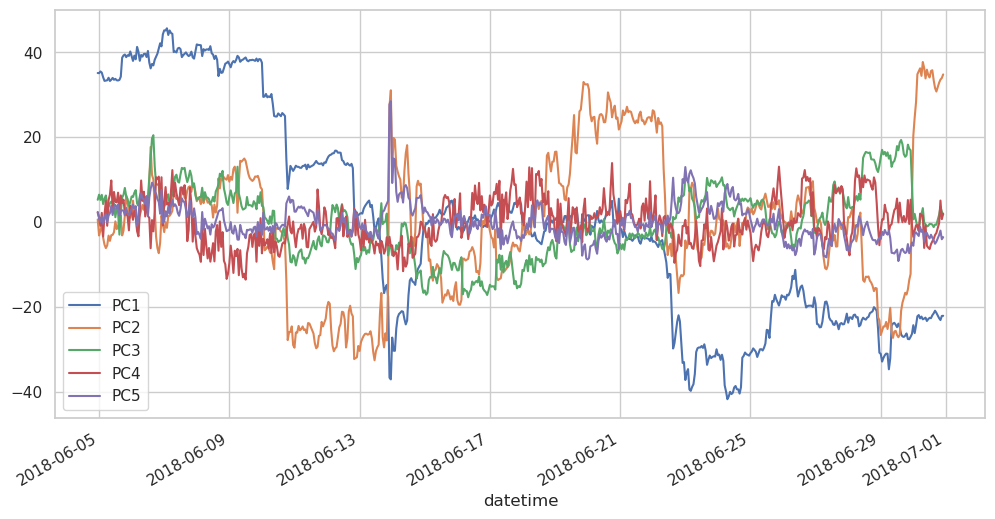

In [10]:
pca_df.plot(figsize=(12, 6))

In [11]:
# explained variance

explained_variance = pca.explained_variance_ratio_.cumsum()
explained_variance

array([0.54683901, 0.78796911, 0.84772339, 0.8745155 , 0.89118161])

## Mean and trend aggregates of OB features

In [28]:
full_data = (
    pl.read_csv(data_path / "btc" / "data_df_with_volume.csv")
    .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
    .sort("datetime")
).to_pandas().set_index("datetime")

In [29]:
# make lagged volatility variables, 4 of them

for i in range(1, 5):
    full_data[f"vol_lag{i}"] = full_data["vol"].shift(i)


In [30]:
columns_list = [
    "spread", 
    # "ask_depth", 
    "bid_depth", 
    # "depth_diff", 
    "ask_volume", 
    "bid_volume", 
    "volume_diff", 
    "weighted_spread", 
    "ask_slope", 
    "bid_slope",
    "volume"
]

In [31]:
for col in columns_list:
    full_data[f'mean_{col}'] = full_data.loc[:, full_data.columns.str.startswith(col)].mean(axis=1)

    full_data[f'trend_{col}'] = full_data.loc[:, full_data.columns.str.startswith(col)].apply(
        lambda x: np.polyfit(range(len(x)), x, 1)[0], axis=1
    )

In [32]:
full_data = full_data.dropna().loc[:, 
                          ['vol'] +# ["volume"] +
                          [f'vol_lag{i}' for i in range(1,5)] +
                          [f'mean_{col}' for col in columns_list] + 
                          [f'trend_{col}' for col in columns_list]
                          ]

In [33]:
full_data

vol  vol_lag1  vol_lag2  vol_lag3  vol_lag4  \
datetime                                                                
2018-06-05 03:00:00  0.000146  0.000502  0.000090  0.000115  0.000143   
2018-06-05 04:00:00  0.000177  0.000146  0.000502  0.000090  0.000115   
2018-06-05 05:00:00  0.000175  0.000177  0.000146  0.000502  0.000090   
2018-06-05 06:00:00  0.000147  0.000175  0.000177  0.000146  0.000502   
2018-06-05 07:00:00  0.000201  0.000147  0.000175  0.000177  0.000146   
...                       ...       ...       ...       ...       ...   
2018-09-30 17:00:00  0.000025  0.000025  0.000032  0.000016  0.000010   
2018-09-30 18:00:00  0.000014  0.000025  0.000025  0.000032  0.000016   
2018-09-30 19:00:00  0.000024  0.000014  0.000025  0.000025  0.000032   
2018-09-30 20:00:00  0.000089  0.000024  0.000014  0.000025  0.000025   
2018-09-30 21:00:00  0.000034  0.000089  0.000024  0.000014  0.000025   

                     mean_spread  mean_bid_depth  mean_ask_volume  \
datetime                                                            
2018-06-05 03:00:00     6.203417     2785.916667      2372.844947   
2018-06-05 04:00:00     4.801000     2772.733333      2395.809942   
2018-06-05 05:00:00     4.060500     2772.891667      2404.858040   
2018-06-05 06:00:00     5.597250     2771.450000      2383.447700   
2018-06-05 07:00:00     4.107000     2781.841667      2292.421042   
...                          ...             ...              ...   
2018-09-30 17:00:00     2.713750     2839.141667      2626.154969   
2018-09-30 18:00:00     3.495083     2842.358333      2610.819406   
2018-09-30 19:00:00     2.176917     2844.933333      2596.672610   
2018-09-30 20:00:00     2.509667     2843.958333      2602.835693   
2018-09-30 21:00:00     3.018167     2838.291667      2659.465413   

                     mean_bid_volume  mean_volume_diff  ...   mean_volume  \
datetime                                                ...                 
2018-06-05 03:00:00     12694.560994     -10321.716046  ... -10231.336438   
2018-06-05 04:00:00     12664.993633     -10269.183692  ... -10182.668599   
2018-06-05 05:00:00     12638.495022     -10233.636982  ... -10147.000811   
2018-06-05 06:00:00     12633.956231     -10250.508530  ... -10164.668004   
2018-06-05 07:00:00     12601.889541     -10309.468499  ... -10221.436029   
...                              ...               ...  ...           ...   
2018-09-30 17:00:00     11914.479492      -9288.324522  ...  -9210.690271   
2018-09-30 18:00:00     11898.818917      -9287.999511  ...  -9211.016675   
2018-09-30 19:00:00     11935.271964      -9338.599354  ...  -9261.014524   
2018-09-30 20:00:00     11947.150624      -9344.314931  ...  -9266.287827   
2018-09-30 21:00:00     11895.432887      -9235.967474  ...  -9157.234463   

                     trend_spread  trend_bid_depth  trend_ask_volume  \
datetime                                                               
2018-06-05 03:00:00      0.016212        -0.399507          0.375979   
2018-06-05 04:00:00     -0.009749         0.039676          0.615733   
2018-06-05 05:00:00      0.040072        -0.068362         -0.651885   
2018-06-05 06:00:00     -0.006928         0.116661         -0.277171   
2018-06-05 07:00:00     -0.006796         0.036075         -0.638825   
...                           ...              ...               ...   
2018-09-30 17:00:00     -0.011085        -0.008067          0.126990   
2018-09-30 18:00:00      0.022473         0.013609         -0.206759   
2018-09-30 19:00:00      0.005222        -0.011549         -0.072756   
2018-09-30 20:00:00      0.005474         0.062473          0.093294   
2018-09-30 21:00:00     -0.010923        -0.008928          0.582496   

                     trend_bid_volume  trend_volume_diff  \
datetime                                                   
2018-06-05 03:00:00         -0.893486           1.269465   
2018-06-05 04:00:00          0.078427           0.537305   

In [34]:
# plot features one by one
def plot_feature(df, feature, problematic_timestamps=None):
    plt.figure(figsize=(12, 3))
    plt.scatter(df.index, df[feature], label=feature, alpha=1, s=0.3)
    plt.title(f"{feature} over time")
    plt.xlabel("Time")
    plt.ylabel(feature)
    plt.legend()

    if problematic_timestamps is not None:
        for timestamp in problematic_timestamps:
            plt.axvline(
                x=timestamp, color="r", linestyle="--", label="Problematic Timestamp"
            )
    plt.show()

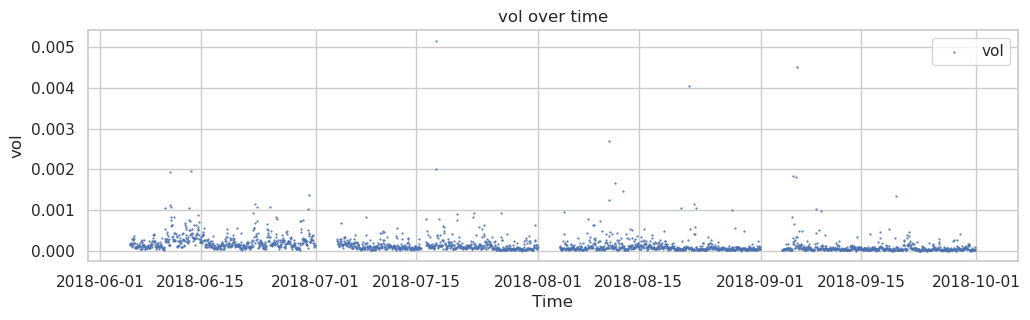

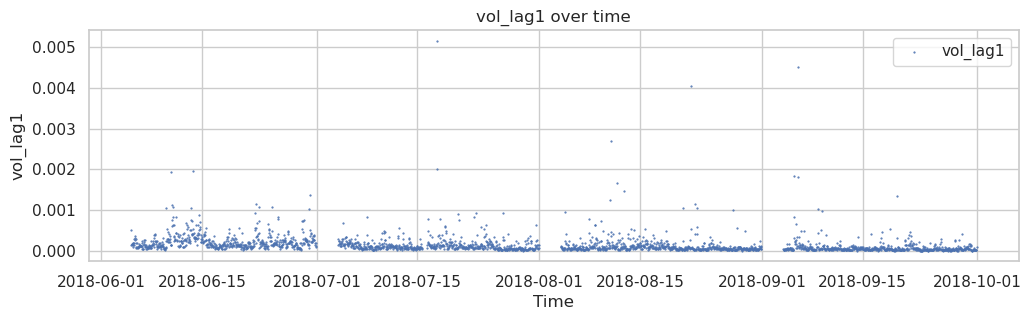

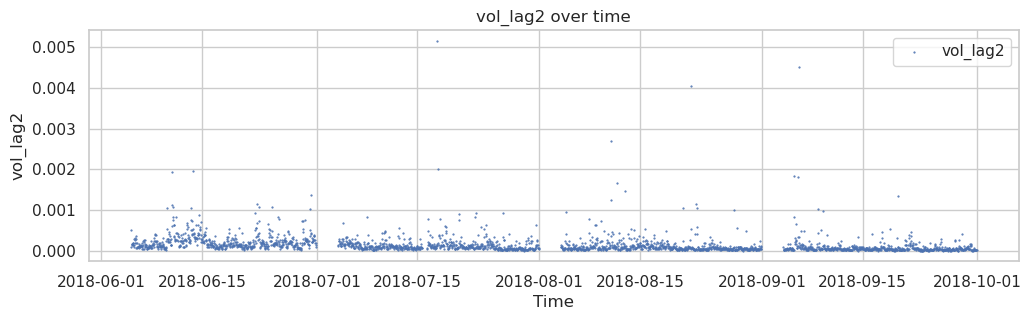

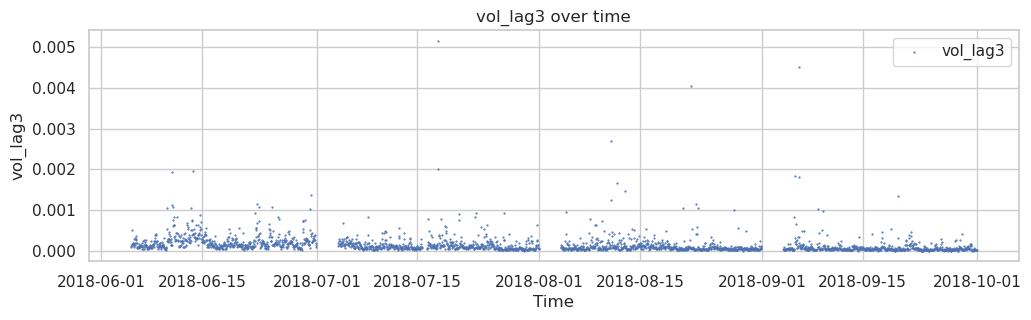

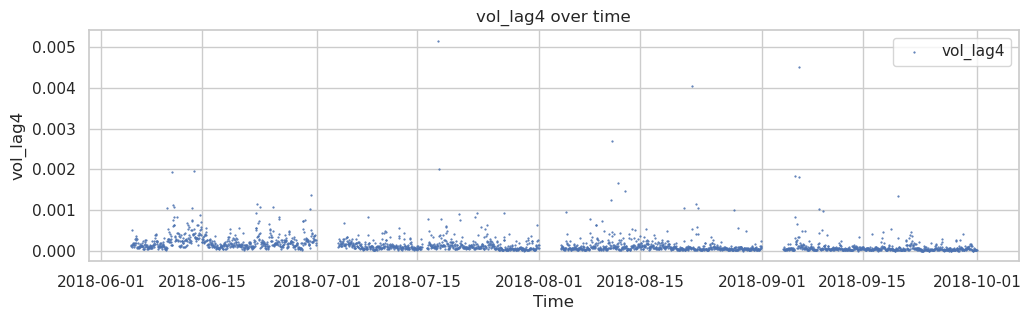

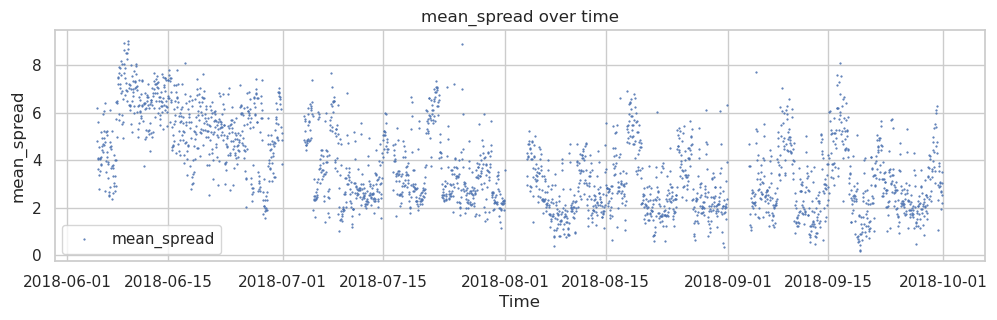

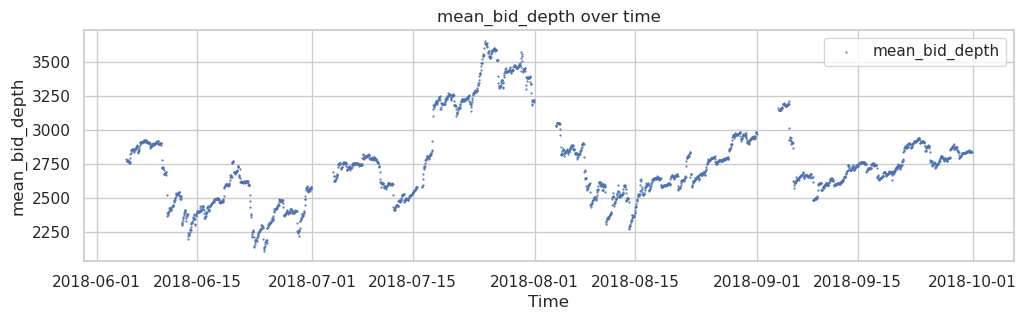

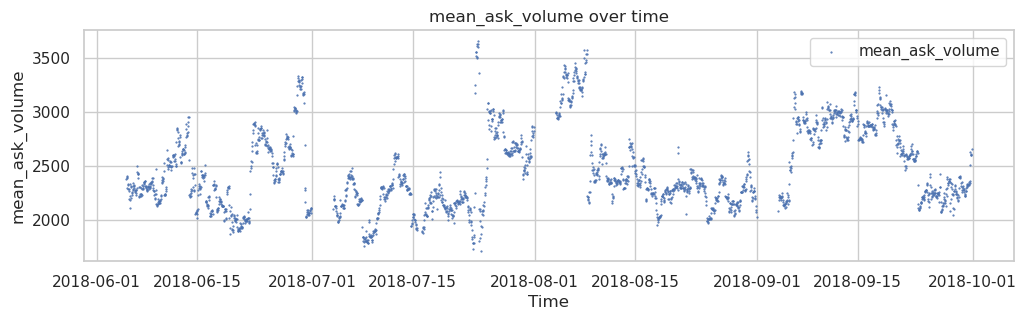

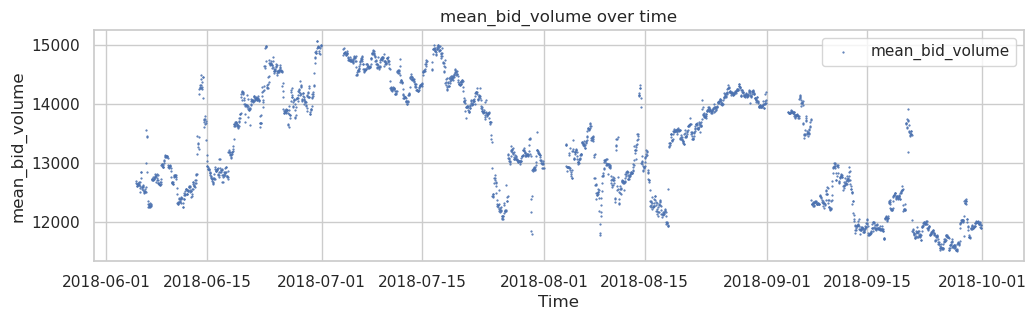

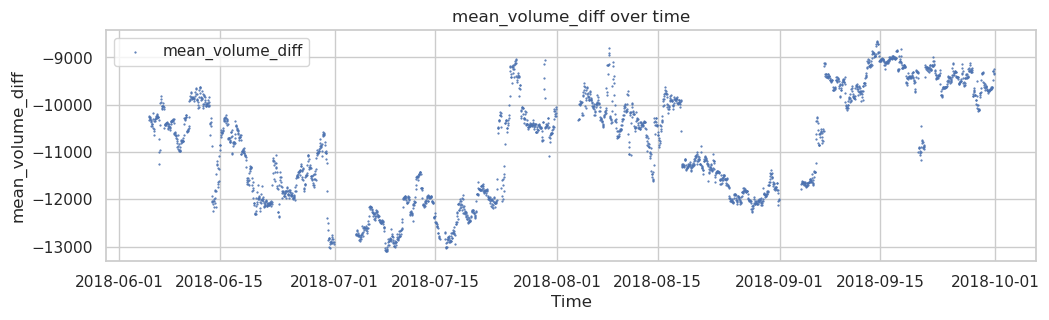

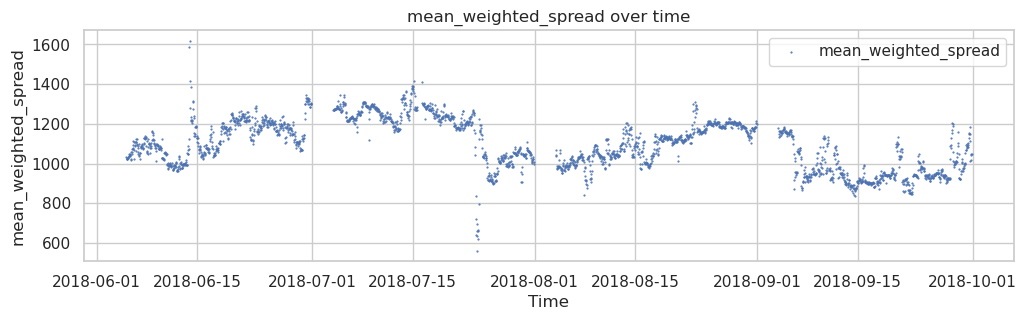

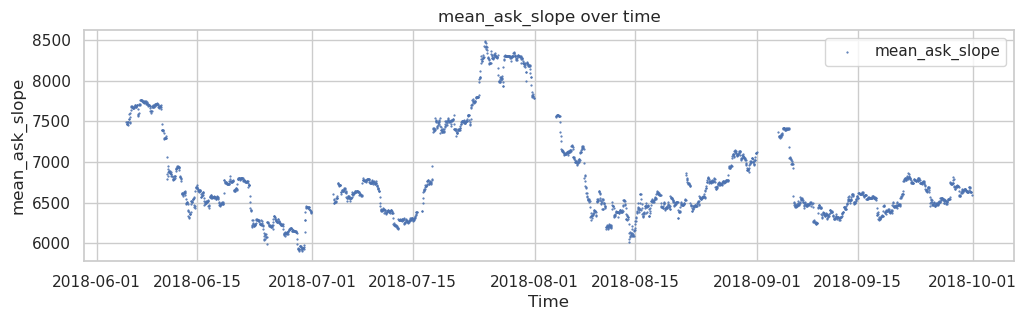

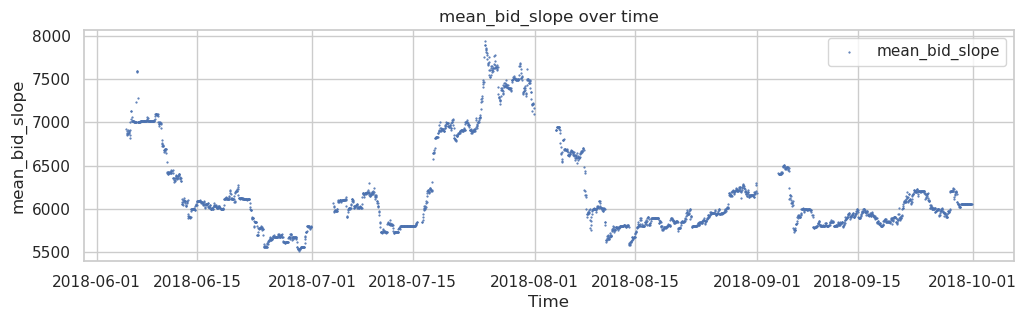

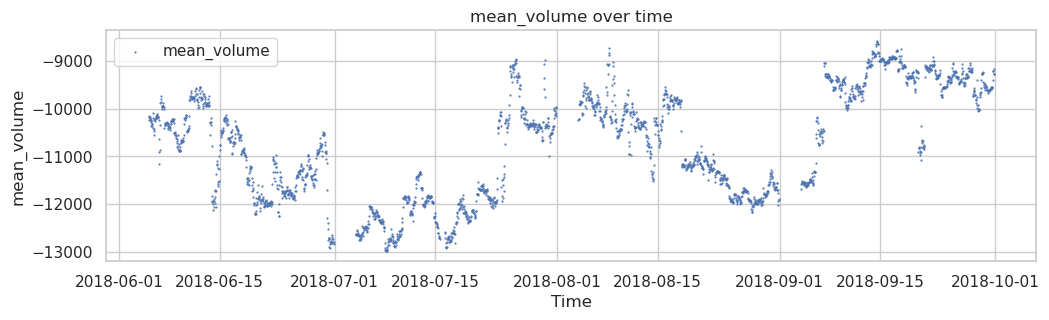

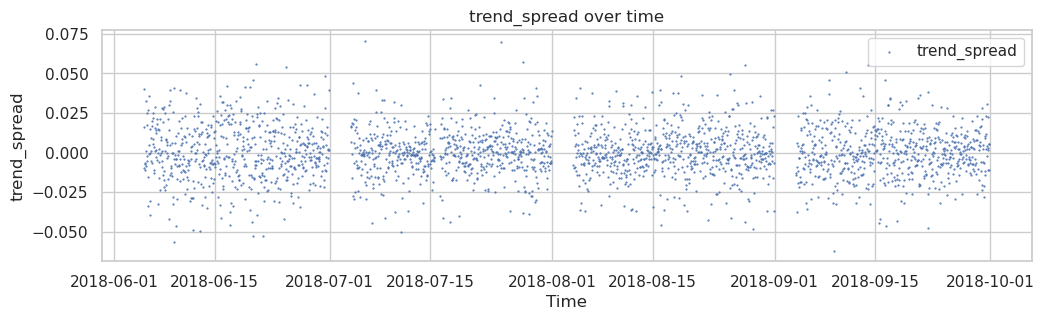

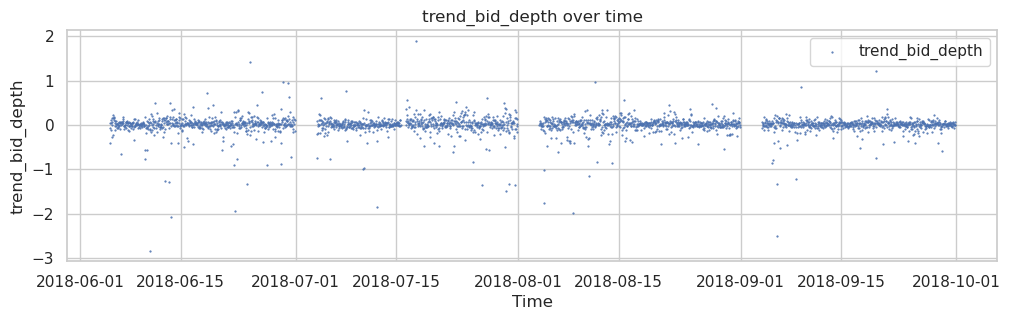

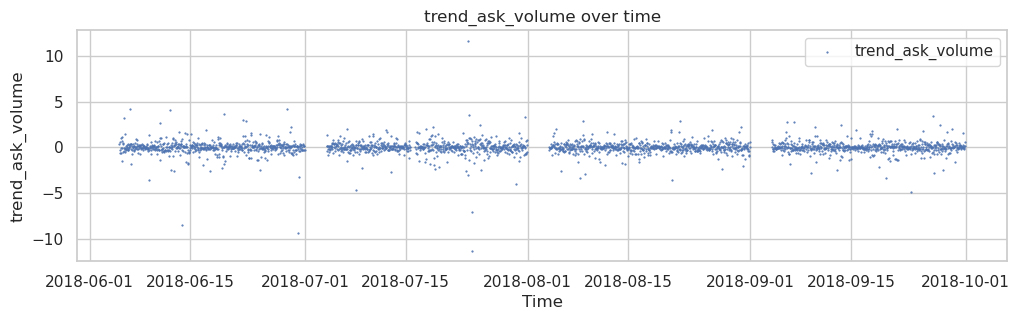

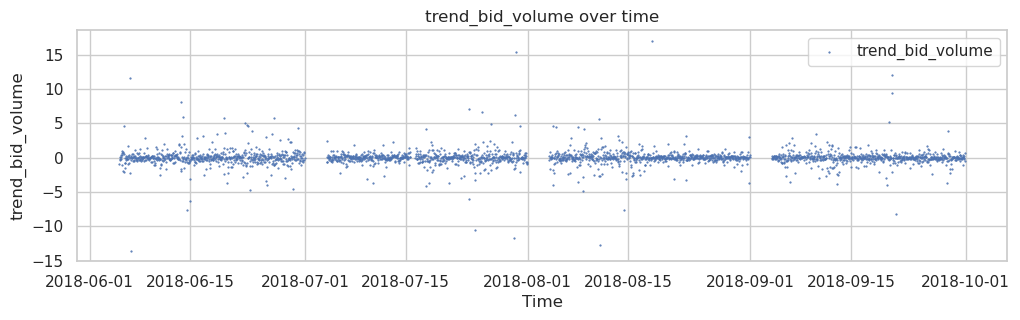

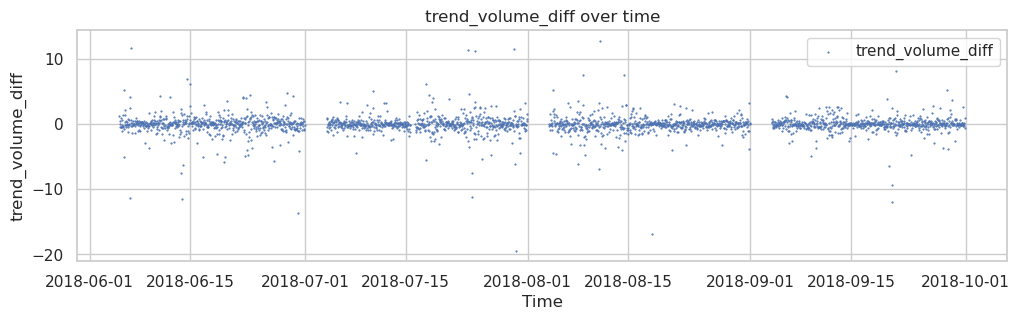

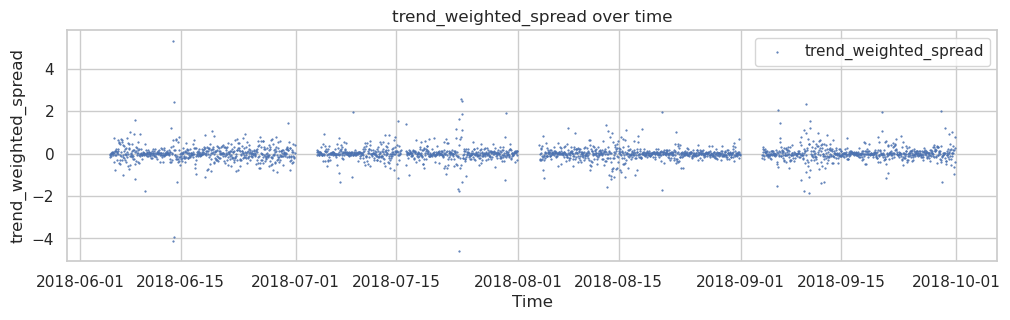

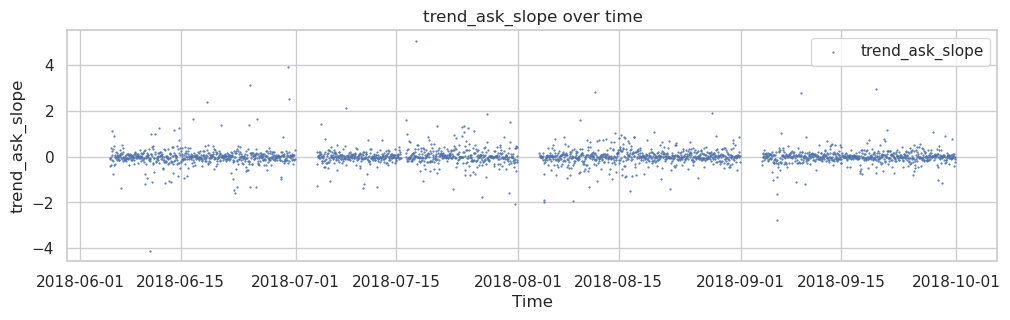

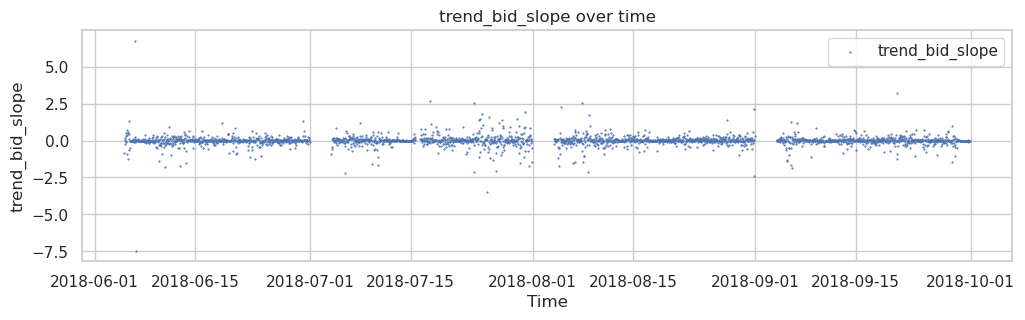

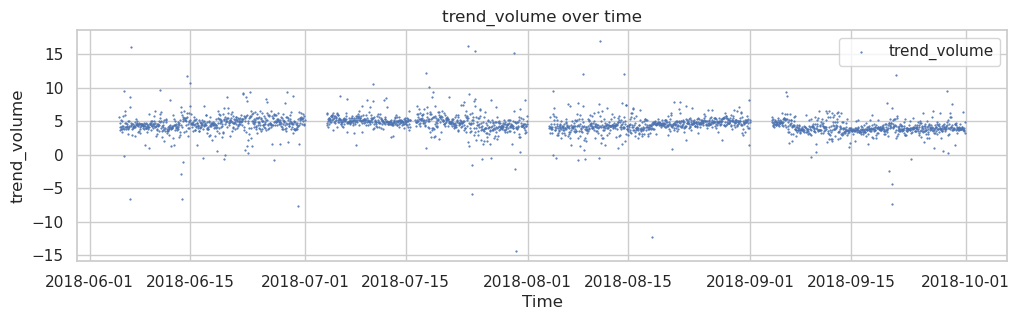

In [35]:
for feature in full_data.columns:
    plot_feature(full_data, feature)

In [19]:
LAST_TRAINING_DATE = datetime.strptime("2018-07-01 00:00:00", "%Y-%m-%d %H:%M:%S")
init_training_vola = full_data.loc[:LAST_TRAINING_DATE]

In [20]:
init_training_vola.describe()

vol    vol_lag1    vol_lag2    vol_lag3    vol_lag4  \
count  617.000000  617.000000  617.000000  617.000000  617.000000   
mean     0.000240    0.000241    0.000241    0.000241    0.000241   
std      0.000211    0.000212    0.000212    0.000212    0.000212   
min      0.000023    0.000023    0.000023    0.000023    0.000023   
25%      0.000116    0.000116    0.000116    0.000115    0.000116   
50%      0.000183    0.000183    0.000183    0.000183    0.000183   
75%      0.000282    0.000282    0.000282    0.000282    0.000282   
max      0.001959    0.001959    0.001959    0.001959    0.001959   

       mean_spread  mean_bid_depth  mean_ask_volume  mean_bid_volume  \
count   617.000000      617.000000       617.000000       617.000000   
mean      5.457221     2529.055389      2407.593699     13486.106116   
std       1.441923      213.914512       320.700411       785.404204   
min       1.546917     2113.608333      1866.562313     12242.951835   
25%       4.564750     2383.583333      2165.357830     12750.510878   
50%       5.593083     2476.308333      2342.686001     13633.951600   
75%       6.511250     2679.958333      2628.609873     14117.857183   
max       9.037417     2929.025000      3329.605814     15078.300956   

       mean_volume_diff  ...  mean_ask_slope  mean_bid_slope  trend_spread  \
count        617.000000  ...      617.000000      617.000000    617.000000   
mean      -11078.512417  ...     6722.026624     6168.382190      0.000576   
std          796.915660  ...      539.445480      489.205258      0.018054   
min       -13018.862201  ...     5909.131417     5516.883250     -0.056716   
25%       -11763.618916  ...     6281.889417     5766.342083     -0.009945   
50%       -11001.611942  ...     6593.065500     6065.914917     -0.000419   
75%       -10406.279502  ...     6891.616583     6403.819250      0.012891   
max        -9619.359726  ...     7766.646583     7589.856750      0.055908   

       trend_bid_depth  trend_ask_volume  trend_bid_volume  trend_volume_diff  \
count       617.000000        617.000000        617.000000         617.000000   
mean         -0.001741          0.005706          0.029855          -0.024149   
std           0.257508          0.869533          1.383475           1.664424   
min          -2.835252         -9.299989        -13.549967         -13.634726   
25%          -0.031679         -0.222956         -0.349094          -0.432342   
50%           0.017394          0.029966         -0.015392           0.080180   
75%           0.069810          0.255973          0.341319           0.518243   
max           1.414230          4.232568         11.543016          11.750891   

       trend_weighted_spread  trend_ask_slope  trend_bid_slope  
count             617.000000       617.000000     6.170000e+02  
mean                0.005676        -0.016356    -1.583465e-02  
std                 0.465231         0.439226     4.922877e-01  
min                -4.138309        -4.104911    -7.451342e+00  
25%                -0.140342        -0.130454    -6.326189e-02  
50%                -0.000413        -0.009010    -3.858893e-14  
75%                 0.153677         0.096834     5.998573e-02  
max                 5.310703         3.901274     6.742483e+00  

[8 rows x 21 columns]

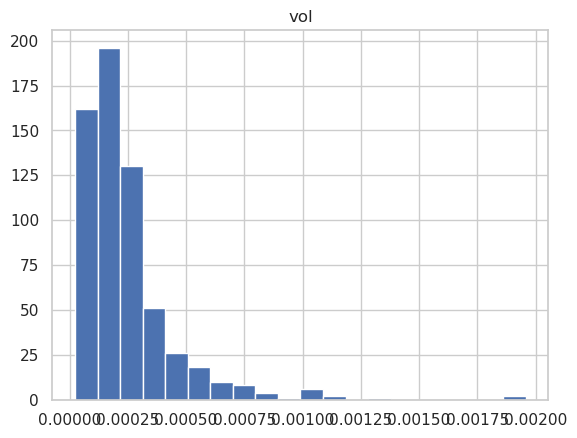

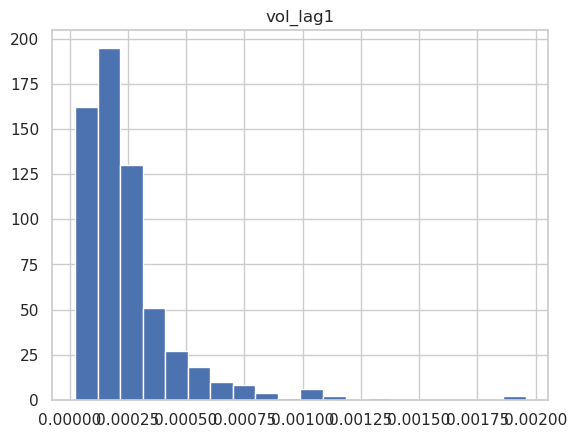

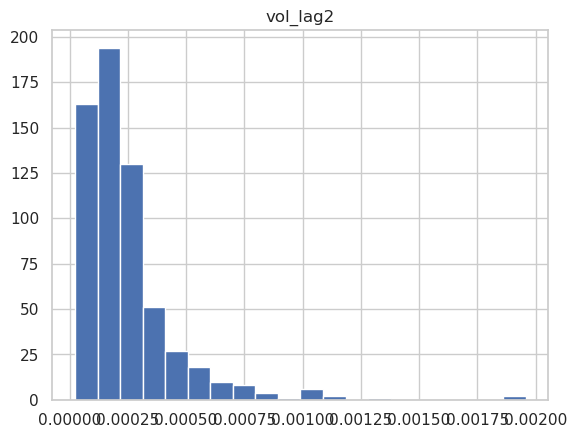

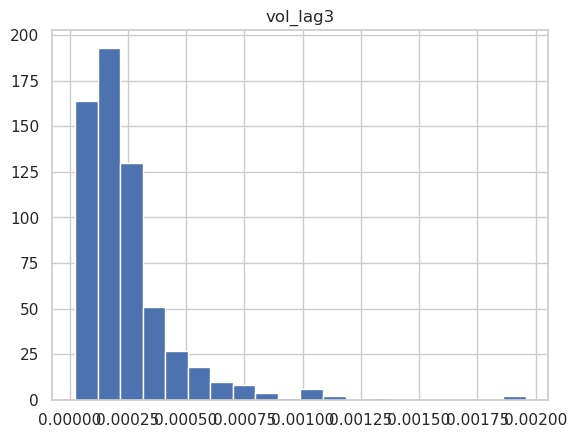

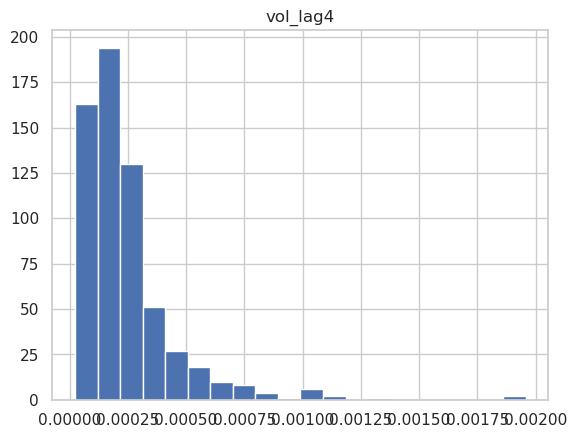

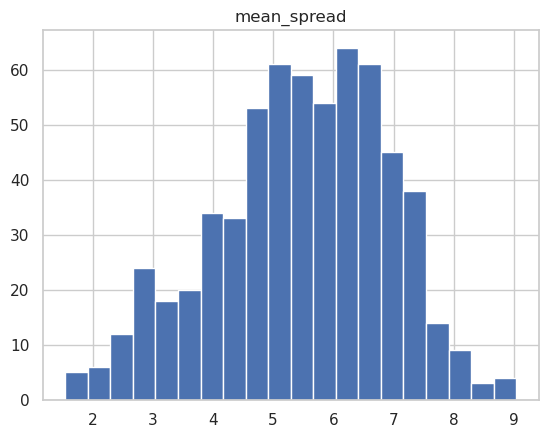

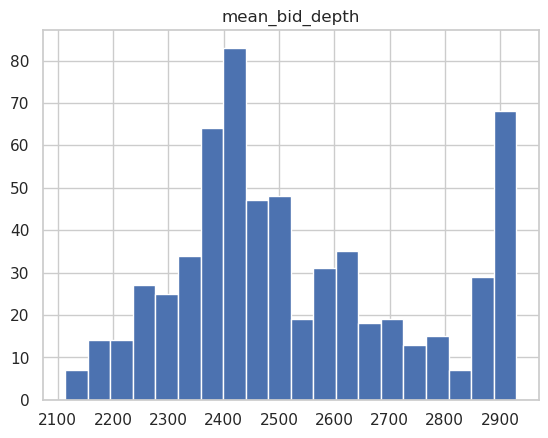

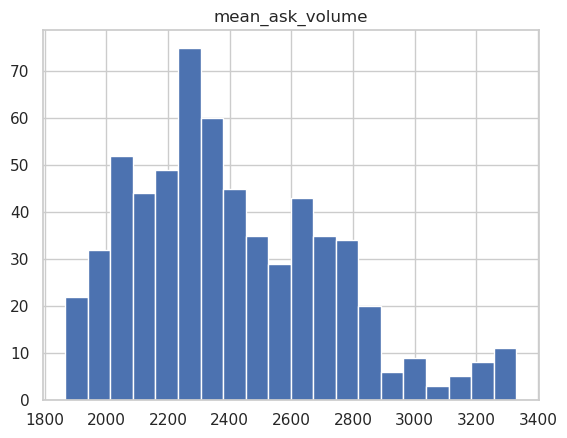

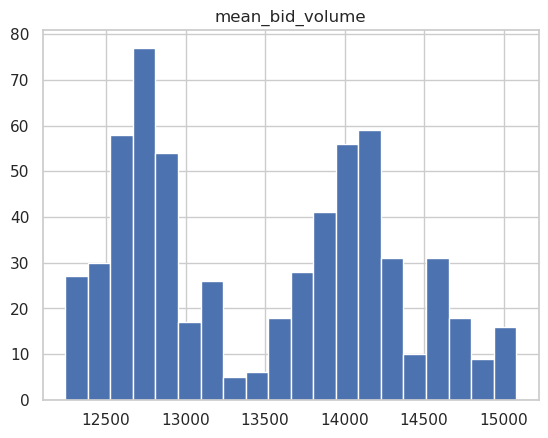

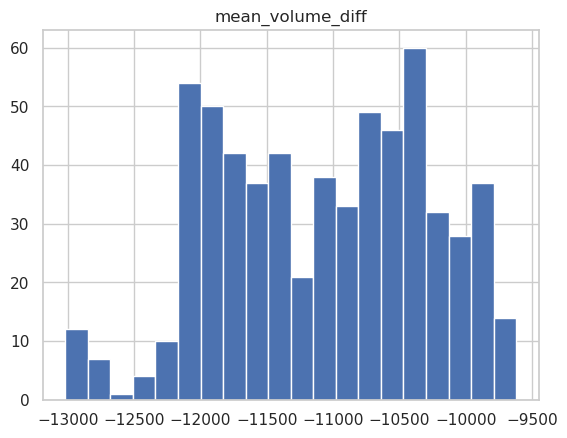

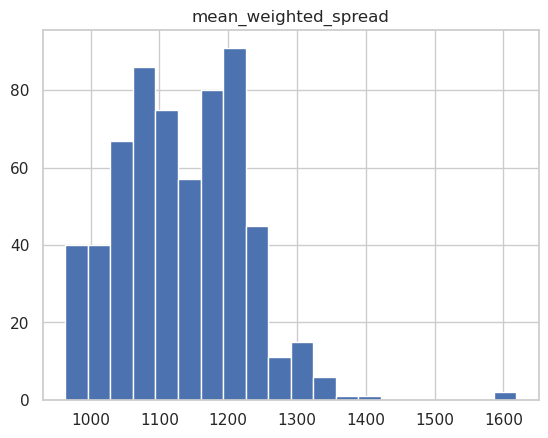

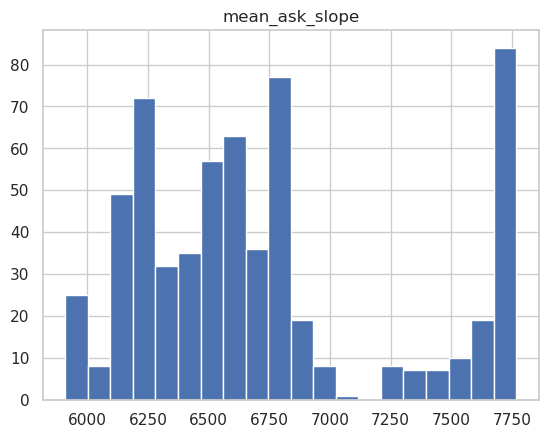

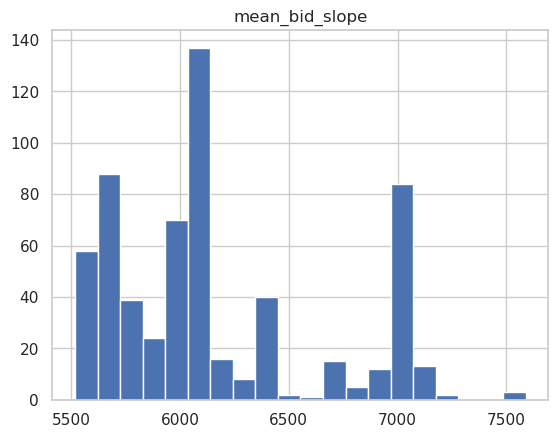

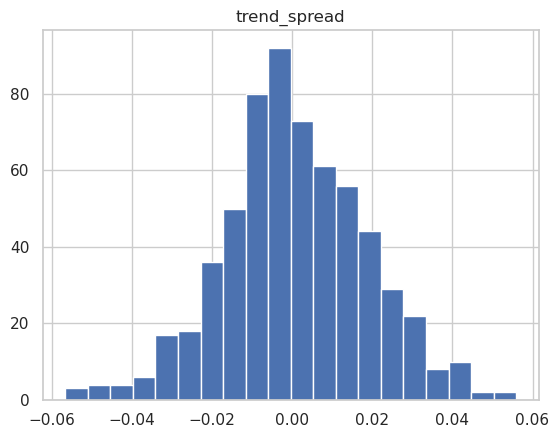

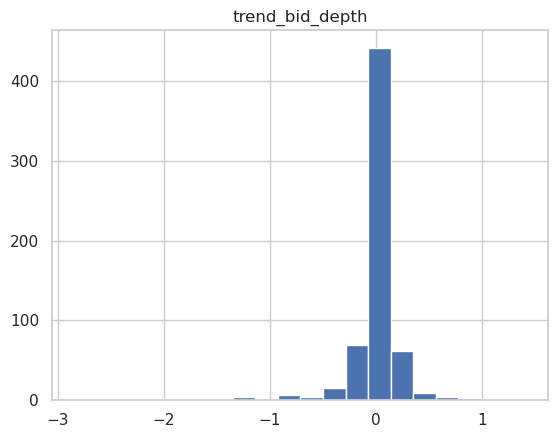

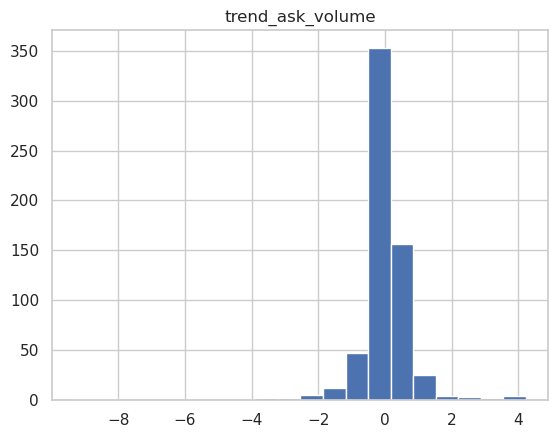

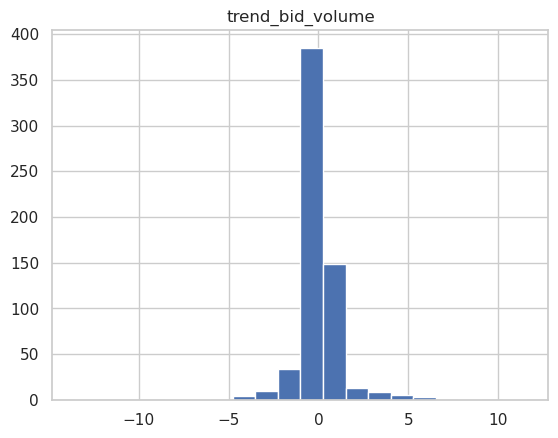

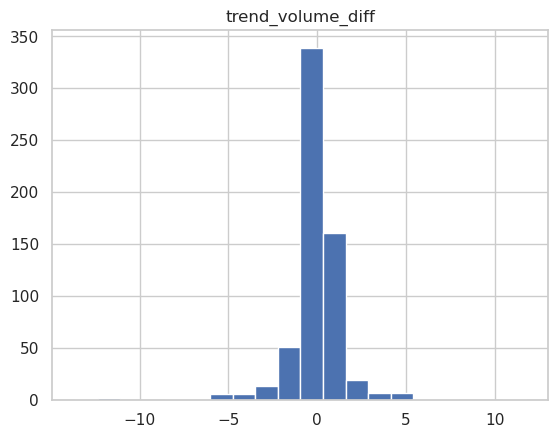

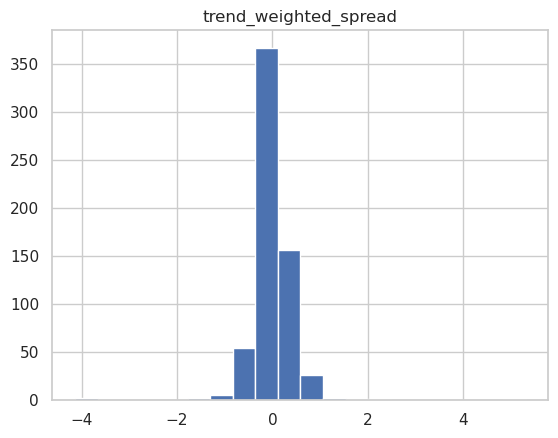

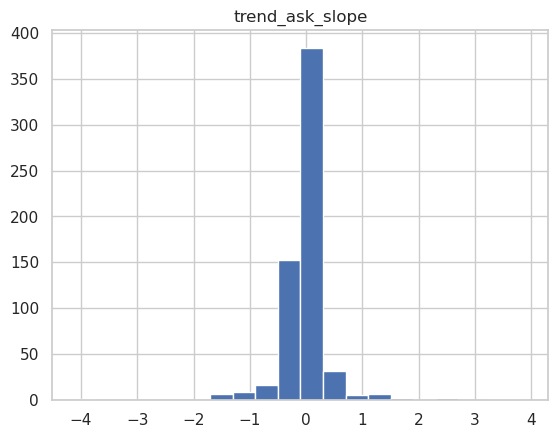

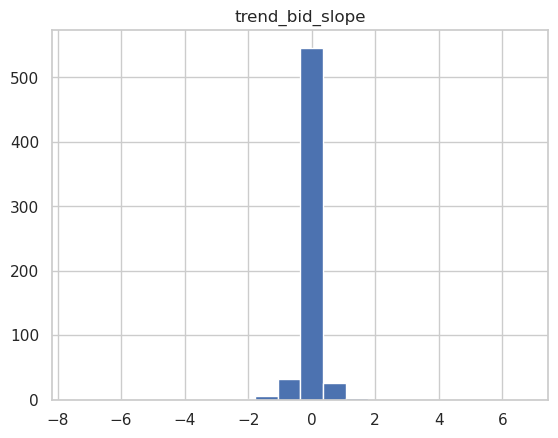

In [21]:
for col in init_training_vola.columns:
    plt.hist(init_training_vola[col], bins=20)
    plt.title(col)
    plt.show()

We should:
1. Winsorize trend variables
2. transform volatility into log volatility
3. Standardize all variables

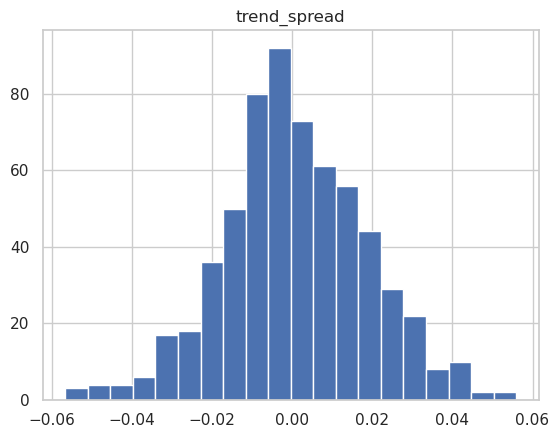

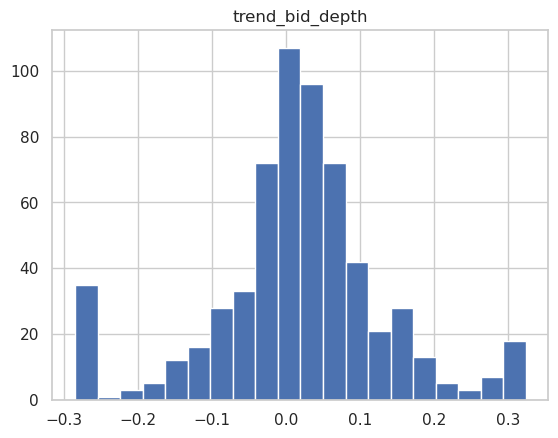

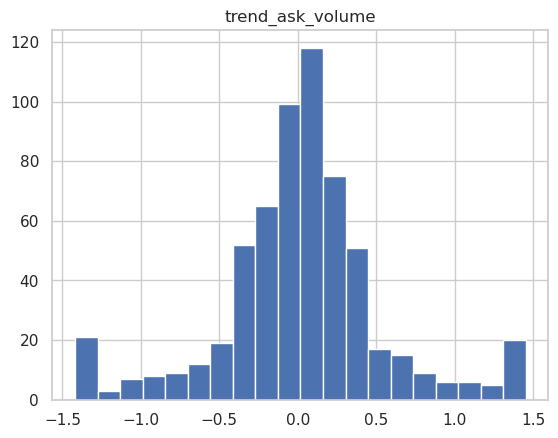

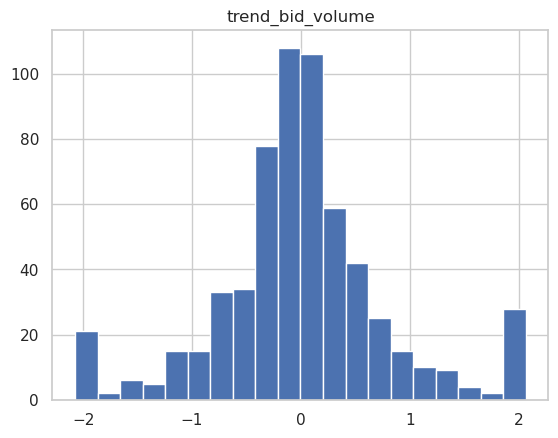

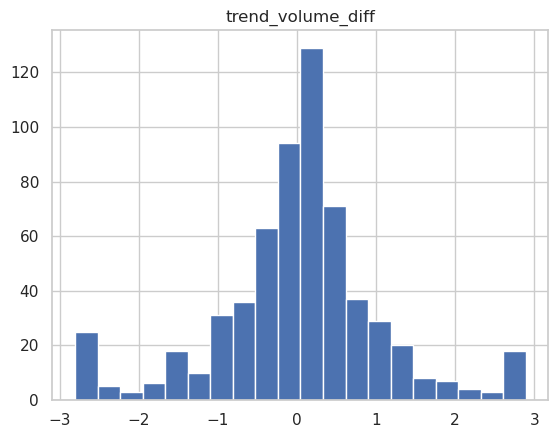

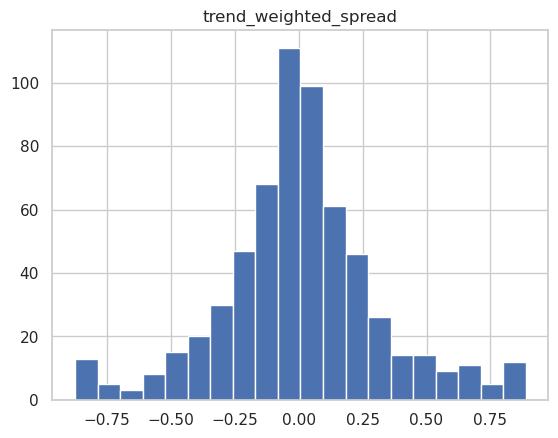

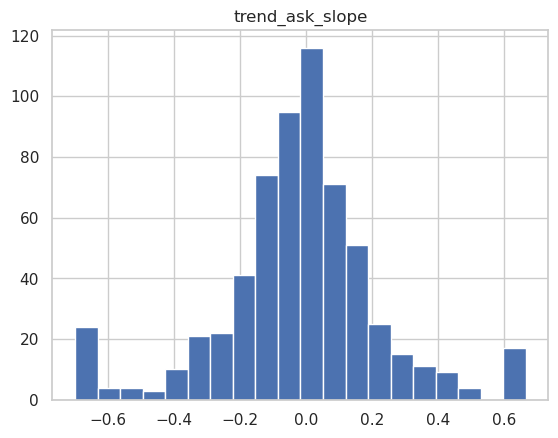

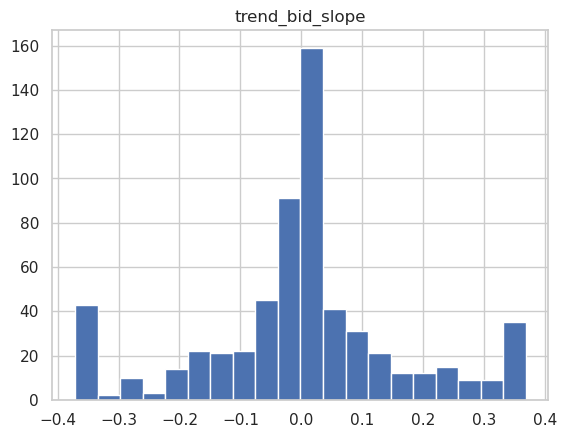

In [22]:
# winsorize trend variables

def winsorize_trend(df, col):
    """
    Winsorize the trend variables to remove outliers
    """
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 2.5 * iqr
    upper_bound = q3 + 2.5 * iqr

    df.loc[:,col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df.loc[:,col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df

for col in init_training_vola.columns:
    if "trend" in col:
        init_training_vola = winsorize_trend(init_training_vola, col)
        plt.hist(init_training_vola[col], bins=20)
        plt.title(col)
        plt.show()

In [23]:
init_training_vola

vol  vol_lag1  vol_lag2  vol_lag3  vol_lag4  \
datetime                                                                
2018-06-05 03:00:00  0.000146  0.000502  0.000090  0.000115  0.000143   
2018-06-05 04:00:00  0.000177  0.000146  0.000502  0.000090  0.000115   
2018-06-05 05:00:00  0.000175  0.000177  0.000146  0.000502  0.000090   
2018-06-05 06:00:00  0.000147  0.000175  0.000177  0.000146  0.000502   
2018-06-05 07:00:00  0.000201  0.000147  0.000175  0.000177  0.000146   
...                       ...       ...       ...       ...       ...   
2018-06-30 17:00:00  0.000154  0.000202  0.000255  0.000383  0.000276   
2018-06-30 19:00:00  0.000089  0.000154  0.000202  0.000255  0.000383   
2018-06-30 20:00:00  0.000202  0.000089  0.000154  0.000202  0.000255   
2018-06-30 21:00:00  0.000126  0.000202  0.000089  0.000154  0.000202   
2018-06-30 22:00:00  0.000144  0.000126  0.000202  0.000089  0.000154   

                     mean_spread  mean_bid_depth  mean_ask_volume  \
datetime                                                            
2018-06-05 03:00:00     6.203417     2785.916667      2372.844947   
2018-06-05 04:00:00     4.801000     2772.733333      2395.809942   
2018-06-05 05:00:00     4.060500     2772.891667      2404.858040   
2018-06-05 06:00:00     5.597250     2771.450000      2383.447700   
2018-06-05 07:00:00     4.107000     2781.841667      2292.421042   
...                          ...             ...              ...   
2018-06-30 17:00:00     6.176167     2557.083333      2092.303235   
2018-06-30 19:00:00     5.389583     2565.350000      2108.711393   
2018-06-30 20:00:00     3.821000     2574.766667      2105.123597   
2018-06-30 21:00:00     5.137833     2586.366667      2101.037744   
2018-06-30 22:00:00     4.835333     2584.116667      2061.931272   

                     mean_bid_volume  mean_volume_diff  ...  mean_ask_slope  \
datetime                                                ...                   
2018-06-05 03:00:00     12694.560994     -10321.716046  ...     7490.462750   
2018-06-05 04:00:00     12664.993633     -10269.183692  ...     7463.342333   
2018-06-05 05:00:00     12638.495022     -10233.636982  ...     7462.075167   
2018-06-05 06:00:00     12633.956231     -10250.508530  ...     7463.747000   
2018-06-05 07:00:00     12601.889541     -10309.468499  ...     7488.274500   
...                              ...               ...  ...             ...   
2018-06-30 17:00:00     14849.814767     -12757.511532  ...     6407.300417   
2018-06-30 19:00:00     14948.667959     -12839.956566  ...     6382.392667   
2018-06-30 20:00:00     15004.766335     -12899.642738  ...     6375.012750   
2018-06-30 21:00:00     14995.197588     -12894.159844  ...     6386.450583   
2018-06-30 22:00:00     14998.221184     -12936.289912  ...     6397.811917   

                     mean_bid_slope  trend_spread  trend_bid_depth  \
datetime                                                             
2018-06-05 03:00:00     6921.164667      0.016212        -0.285404   
2018-06-05 04:00:00     6894.615667     -0.009749         0.039676   
2018-06-05 05:00:00     6876.743750      0.040072        -0.068362   
2018-06-05 06:00:00     6869.339083     -0.006928         0.116661   
2018-06-05 07:00:00     6855.488167     -0.006796         0.036075   
...                             ...           ...              ...   
2018-06-30 17:00:00     5766.342083      0.002489         0.067977   
2018-06-30 19:00:00     5797.928917     -0.003386         0.023522   
2018-06-30 20:00:00     5791.052917      0.001793         0.132294   
2018-06-30 21:00:00     5793.017667      0.039725         0.121217   
2018-06-30 22:00:00     5792.877083      0.001591        -0.125599   

                     trend_ask_volume  trend_bid_volume  trend_volume_diff  \
datetime                                                                     
2018-06-05 03:00:00          0.375979         -0.893486           1.269465   
2018-

/tmp/ipykernel_45111/781432485.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  init_training_vola.loc[:,"log_vol"] = np.log(init_training_vola["vol"])


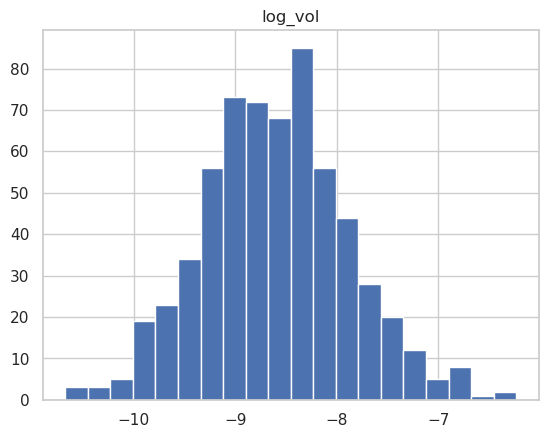

In [24]:
# make log vol

init_training_vola.loc[:,"log_vol"] = np.log(init_training_vola["vol"])
plt.hist(init_training_vola.loc[:,f"log_vol"], bins=20)
plt.title(f"log_vol")
plt.show()

In [25]:
for i in range(1, 5):
    init_training_vola.loc[:,f"log_vol_lag{i}"] = init_training_vola["log_vol"].shift(i)

/tmp/ipykernel_45111/3629175701.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  init_training_vola.loc[:,f"log_vol_lag{i}"] = init_training_vola["log_vol"].shift(i)
/tmp/ipykernel_45111/3629175701.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  init_training_vola.loc[:,f"log_vol_lag{i}"] = init_training_vola["log_vol"].shift(i)
/tmp/ipykernel_45111/3629175701.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# standarzize the data, output pandas dataframe
columns = init_training_vola.columns
index = init_training_vola.index
init_training_vola = scaler.fit_transform(init_training_vola)
init_training_vola = pd.DataFrame(init_training_vola, columns=columns, index=index)

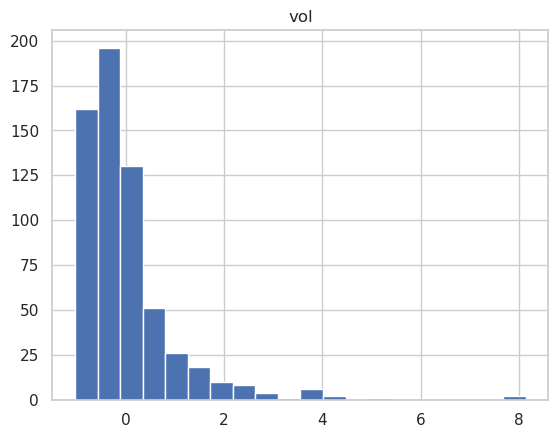

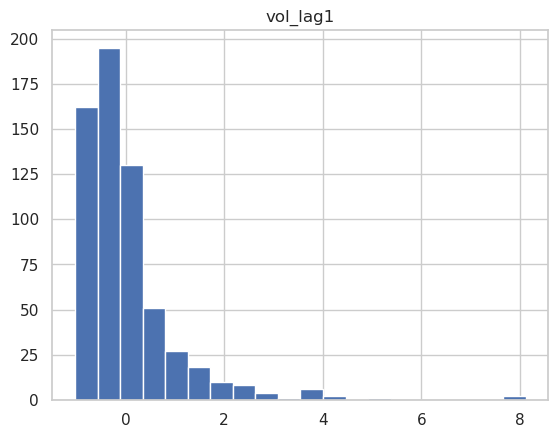

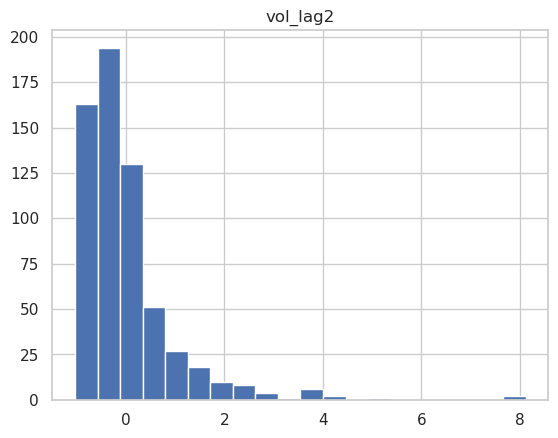

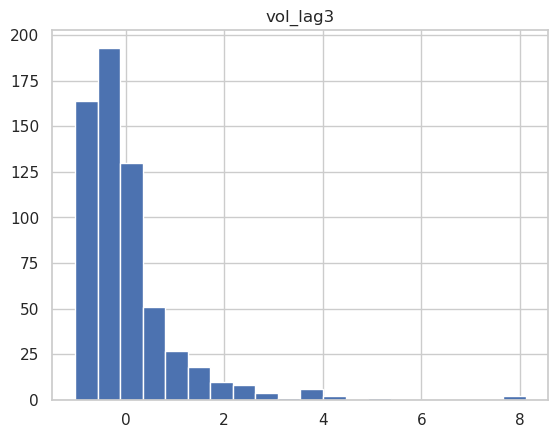

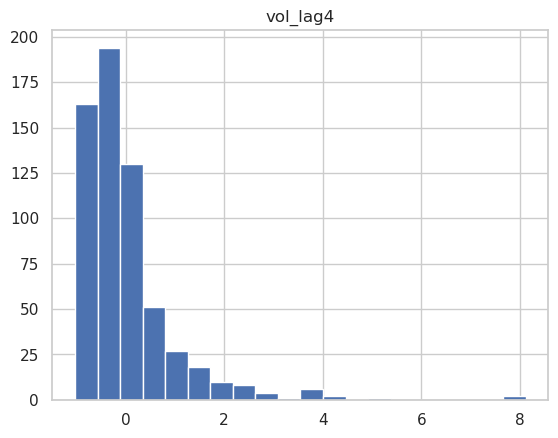

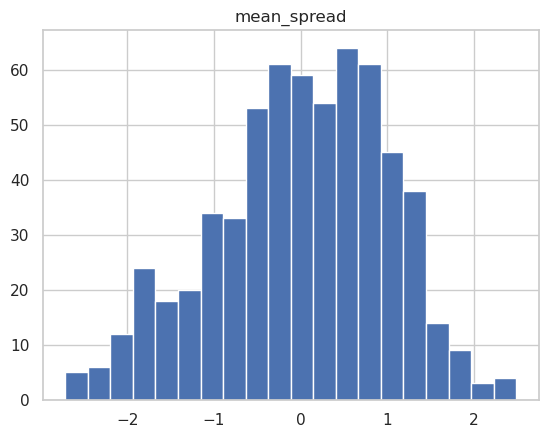

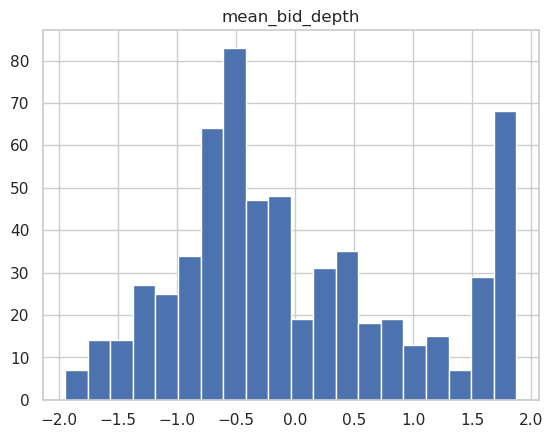

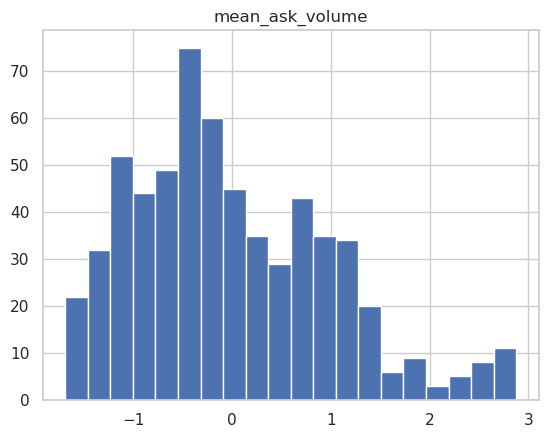

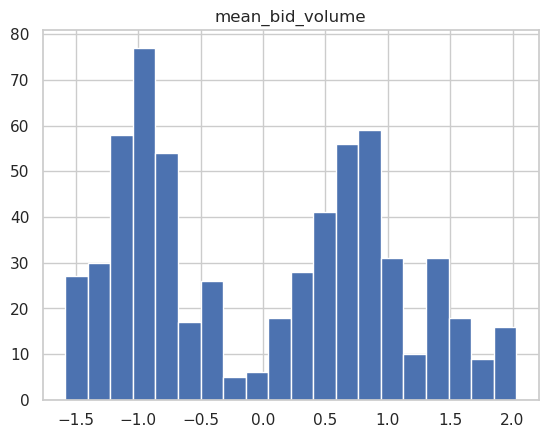

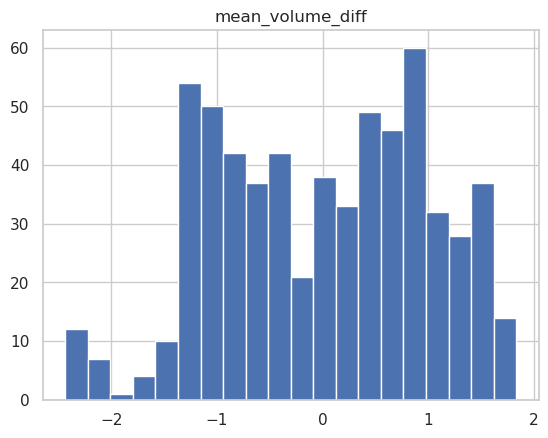

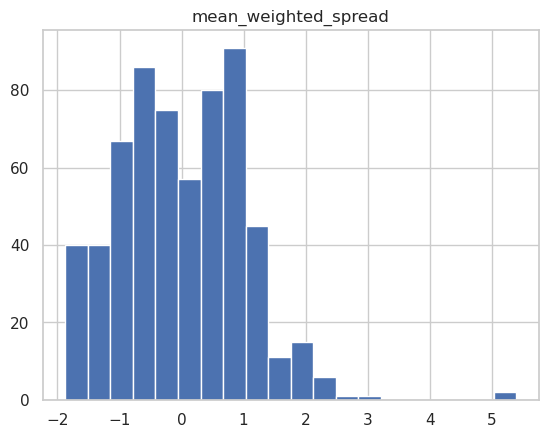

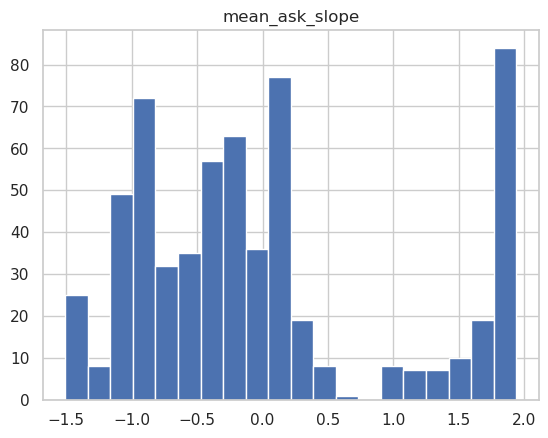

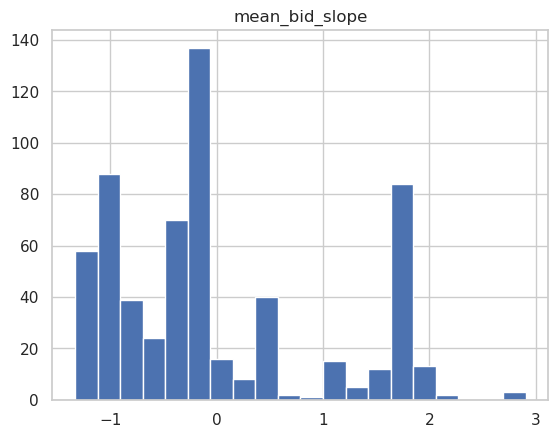

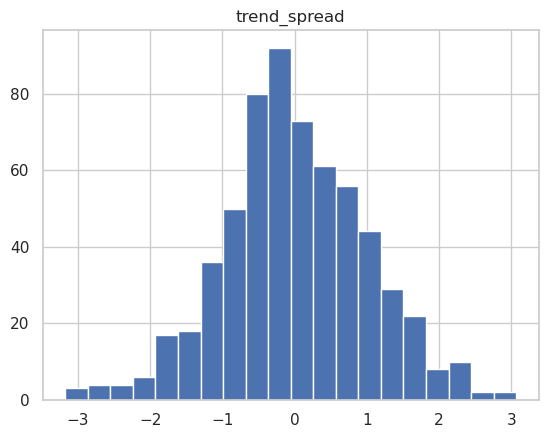

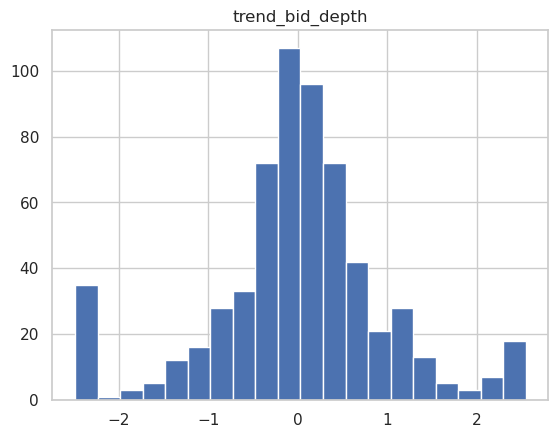

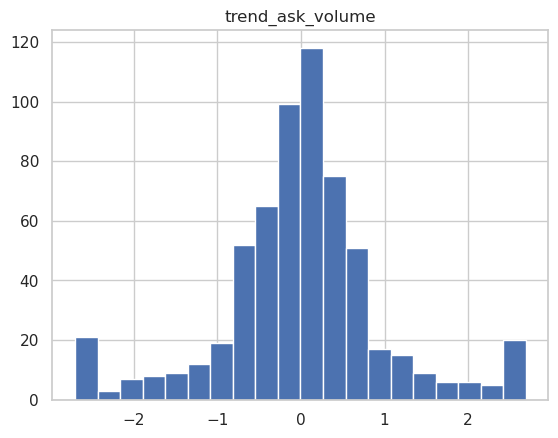

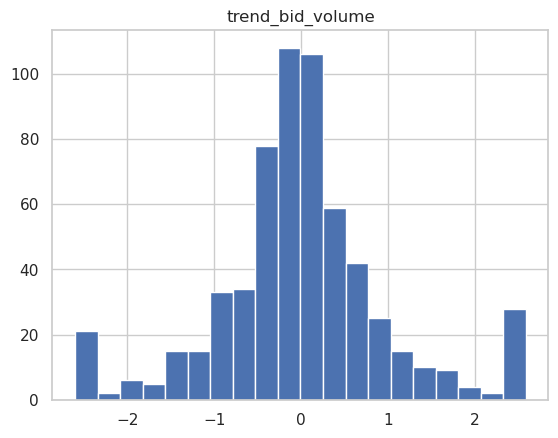

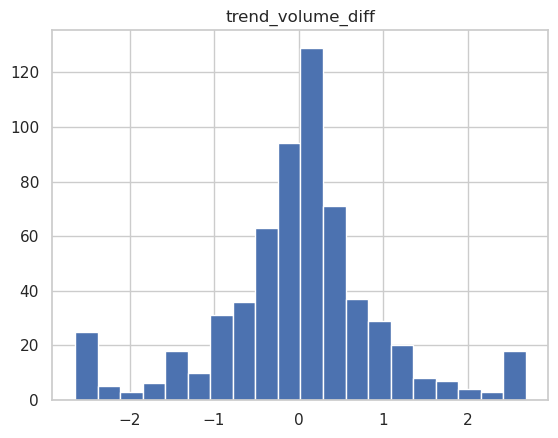

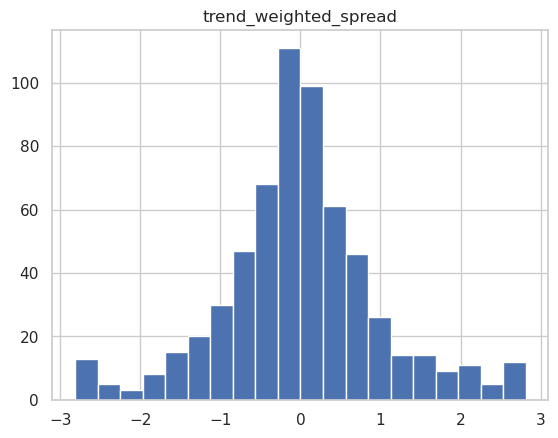

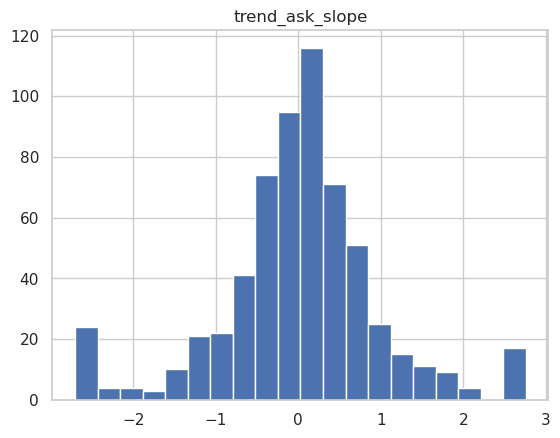

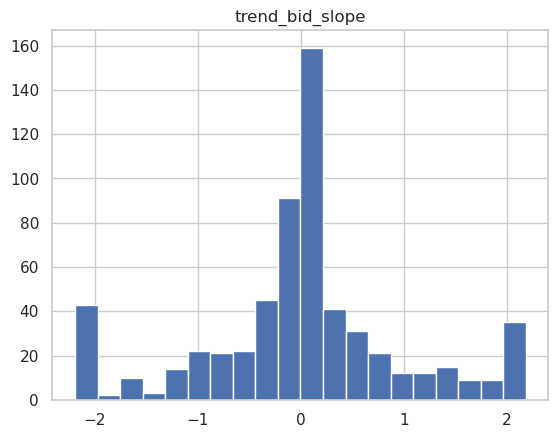

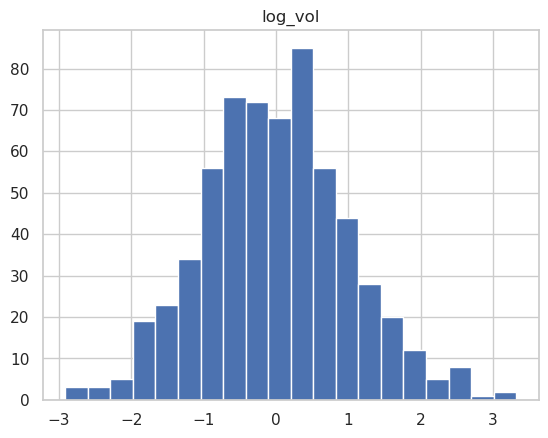

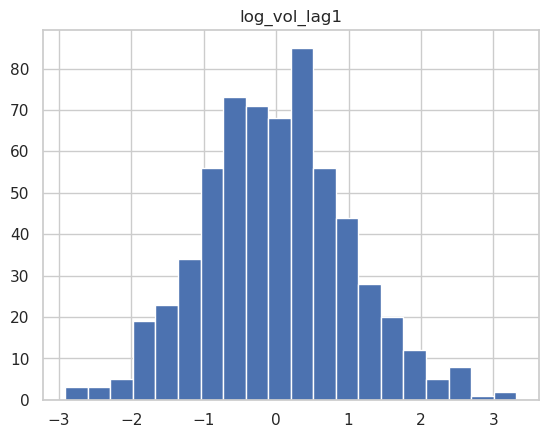

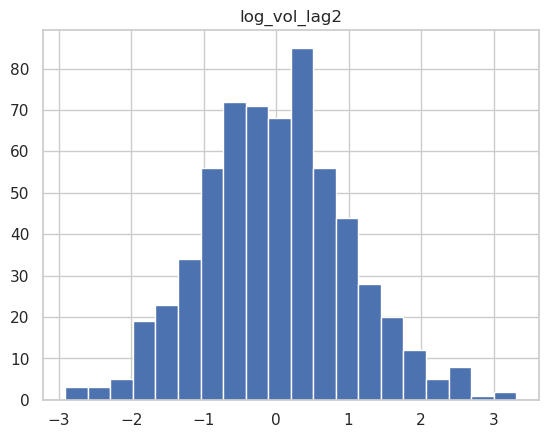

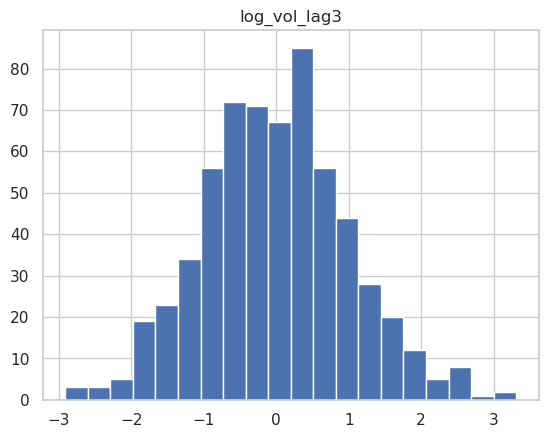

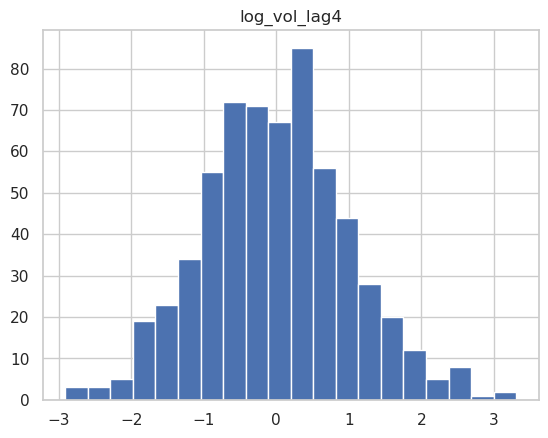

In [27]:
# plot histogram of the data
for col in init_training_vola.columns:
    plt.hist(init_training_vola[col], bins=20)
    plt.title(col)
    plt.show()

In [28]:
def winsorize_trend(df, col):
    """
    Winsorize the trend variables to remove outliers
    """
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 2.5 * iqr
    upper_bound = q3 + 2.5 * iqr

    df.loc[:,col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df.loc[:,col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df

In [29]:
full_data = (
    pl.read_csv(data_path / "btc" / "data_df.csv")
    .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
    .sort("datetime")
).to_pandas().set_index("datetime")

# for i in range(1, 5):
#     full_data[f"vol_lag{i}"] = full_data["vol"].shift(i)


ob_features_list = [
    "spread", 
    # "ask_depth", 
    "bid_depth", 
    # "depth_diff", 
    "ask_volume", 
    "bid_volume", 
    "volume_diff", 
    "weighted_spread", 
    "ask_slope", 
    "bid_slope"
]

for col in ob_features_list:
    full_data[f'mean_{col}'] = full_data.loc[:, full_data.columns.str.startswith(col)].mean(axis=1)

    full_data[f'trend_{col}'] = full_data.loc[:, full_data.columns.str.startswith(col)].apply(
        lambda row: np.polyfit(range(len(row)), row, 1)[0], axis=1
    )

full_data = full_data.dropna().loc[:, 
                          ['vol'] +
                          #[f'vol_lag{i}' for i in range(1,5)] +
                          [f'mean_{col}' for col in ob_features_list] + 
                          [f'trend_{col}' for col in ob_features_list]
                          ]



for col in full_data.columns:
    if "trend" in col:
        full_data = winsorize_trend(full_data, col)
        print(col)

trend_spread
trend_bid_depth
trend_ask_volume
trend_bid_volume
trend_volume_diff
trend_weighted_spread
trend_ask_slope
trend_bid_slope


In [30]:
full_data = (
    pl.read_csv(data_path / "btc" / "data_df.csv")
    .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
    .sort("datetime")
    ).to_pandas().set_index("datetime")

In [31]:
# make lagged volatility variables, 4 of them

for i in range(1, 5):
    full_data[f"vol_lag{i}"] = full_data["vol"].shift(i)

# add log volatilities
full_data["log_vol"] = np.log(full_data["vol"])
for i in range(1, 5):
    full_data[f"log_vol_lag{i}"] = full_data["log_vol"].shift(i)

ob_features = [
    "spread", 
    # "ask_depth", 
    "bid_depth", 
    # "depth_diff", 
    "ask_volume", 
    "bid_volume", 
    "volume_diff", 
    "weighted_spread", 
    "ask_slope", 
    "bid_slope"
]

for col in ob_features:
    full_data[f'mean_{col}'] = full_data.loc[:, full_data.columns.str.startswith(col)].mean(axis=1)

    full_data[f'trend_{col}'] = full_data.loc[:, full_data.columns.str.startswith(col)].apply(
        lambda x: np.polyfit(range(len(x)), x, 1)[0], axis=1
    )
dataset = full_data.dropna().loc[:, 
                          ['vol' ] + ['ret'] + ['log_vol'] +
                          [f'vol_lag{i}' for i in range(1,5)] +
                          #[f'log_vol_lag{i}' for i in range(1,5)] +
                          [f'mean_{col}' for col in ob_features] + 
                          [f'trend_{col}' for col in ob_features]
                          ]

In [32]:
def winsorize_trend(df, col):
    """
    Winsorize the trend variables to remove outliers
    """
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 2.5 * iqr
    upper_bound = q3 + 2.5 * iqr

    df.loc[:,col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df.loc[:,col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df

In [33]:
LAST_TRAINING_DATE = datetime.strptime("2018-06-30 23:59:59", "%Y-%m-%d %H:%M:%S")
init_training_vola = dataset.loc[:LAST_TRAINING_DATE]

In [34]:
init_training_vola.drop(columns=['ret', 'log_vol'], inplace=True)

/tmp/ipykernel_45111/1859162819.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  init_training_vola.drop(columns=['ret', 'log_vol'], inplace=True)


Winsorization does not change the conclusion about what variables are correlated with volatility. Comment out the following cell to skip the winsorization step.

In [35]:
for col in init_training_vola.columns:
    if "trend" in col:
        init_training_vola = winsorize_trend(init_training_vola, col)

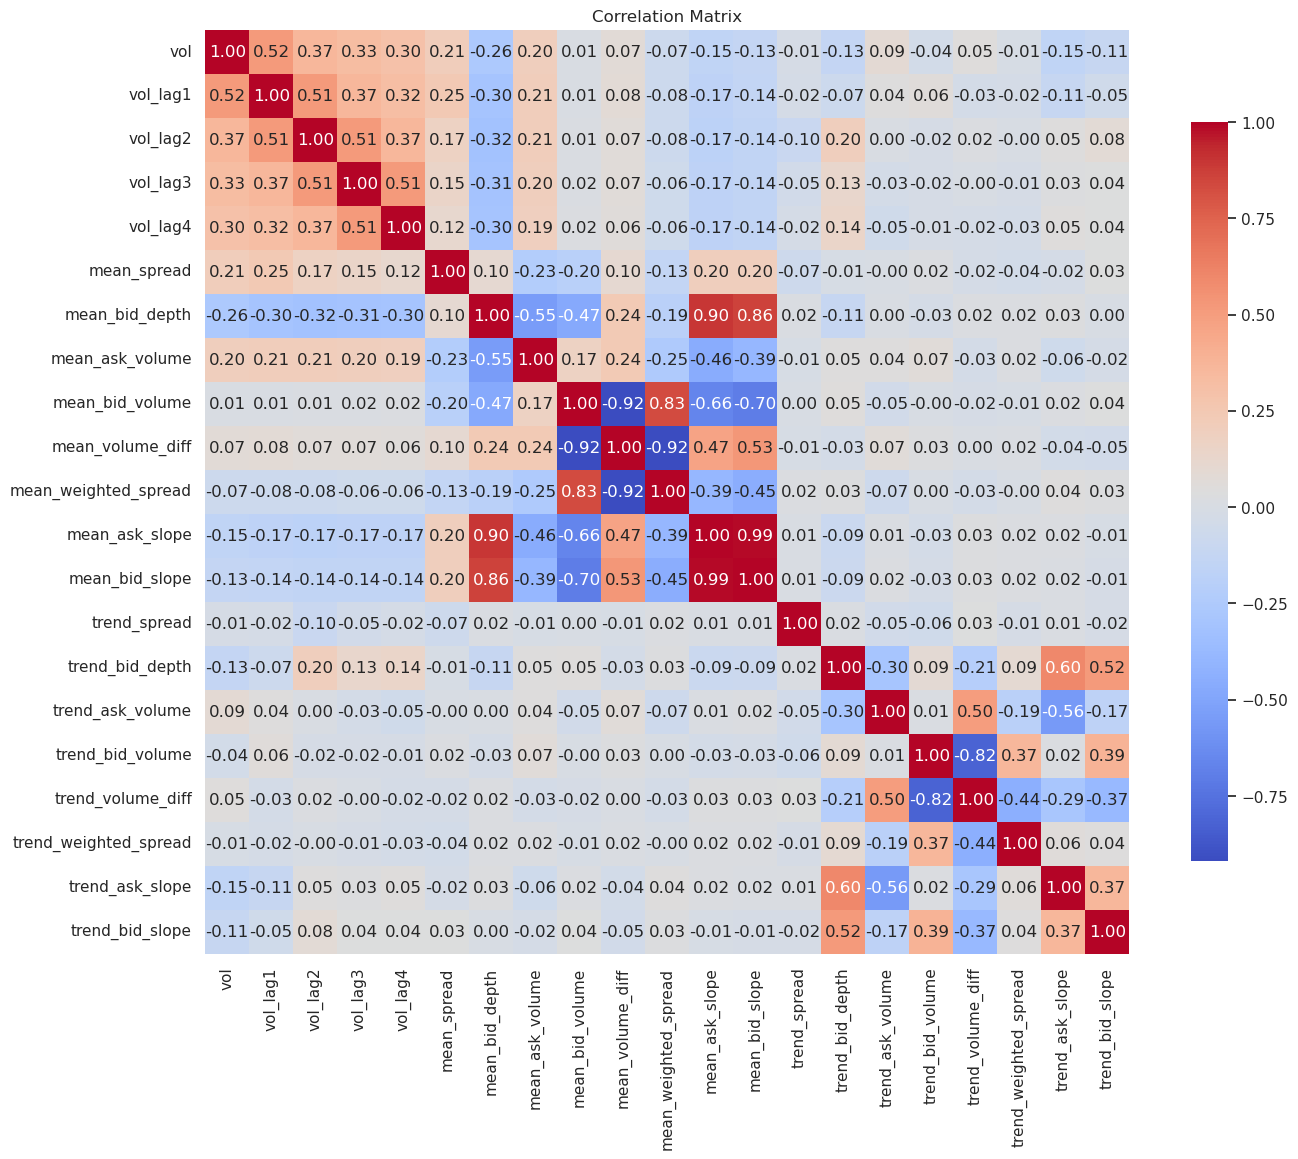

In [36]:
# correlation matrix
corr = init_training_vola.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix")
plt.show()



In [37]:
# drop
['mean_bid_volume',
    'trend_spread',
    'trend_ask_volume',
    'trend_bid_volume', 
    'trend_volume_diff', 
    'trend_weighted_spread',
]

['mean_bid_volume',
 'trend_spread',
 'trend_ask_volume',
 'trend_bid_volume',
 'trend_volume_diff',
 'trend_weighted_spread']

<Axes: >

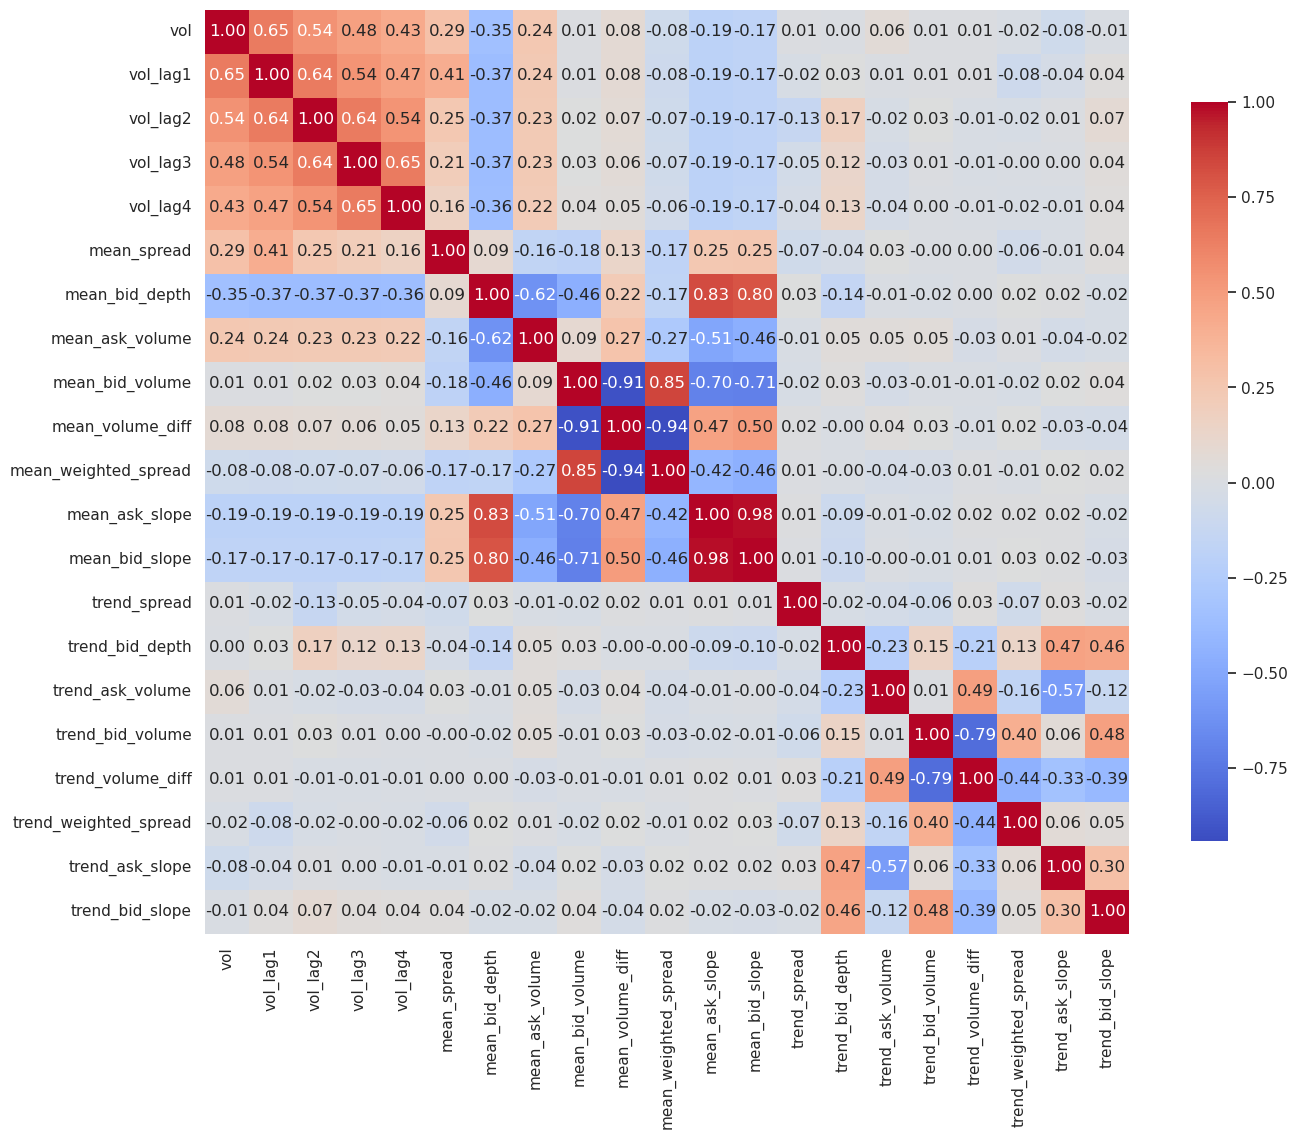

In [38]:
# compute spearman correlation
spearman_corr = init_training_vola.corr(method='spearman')
plt.figure(figsize=(16, 12))
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})

<Axes: >

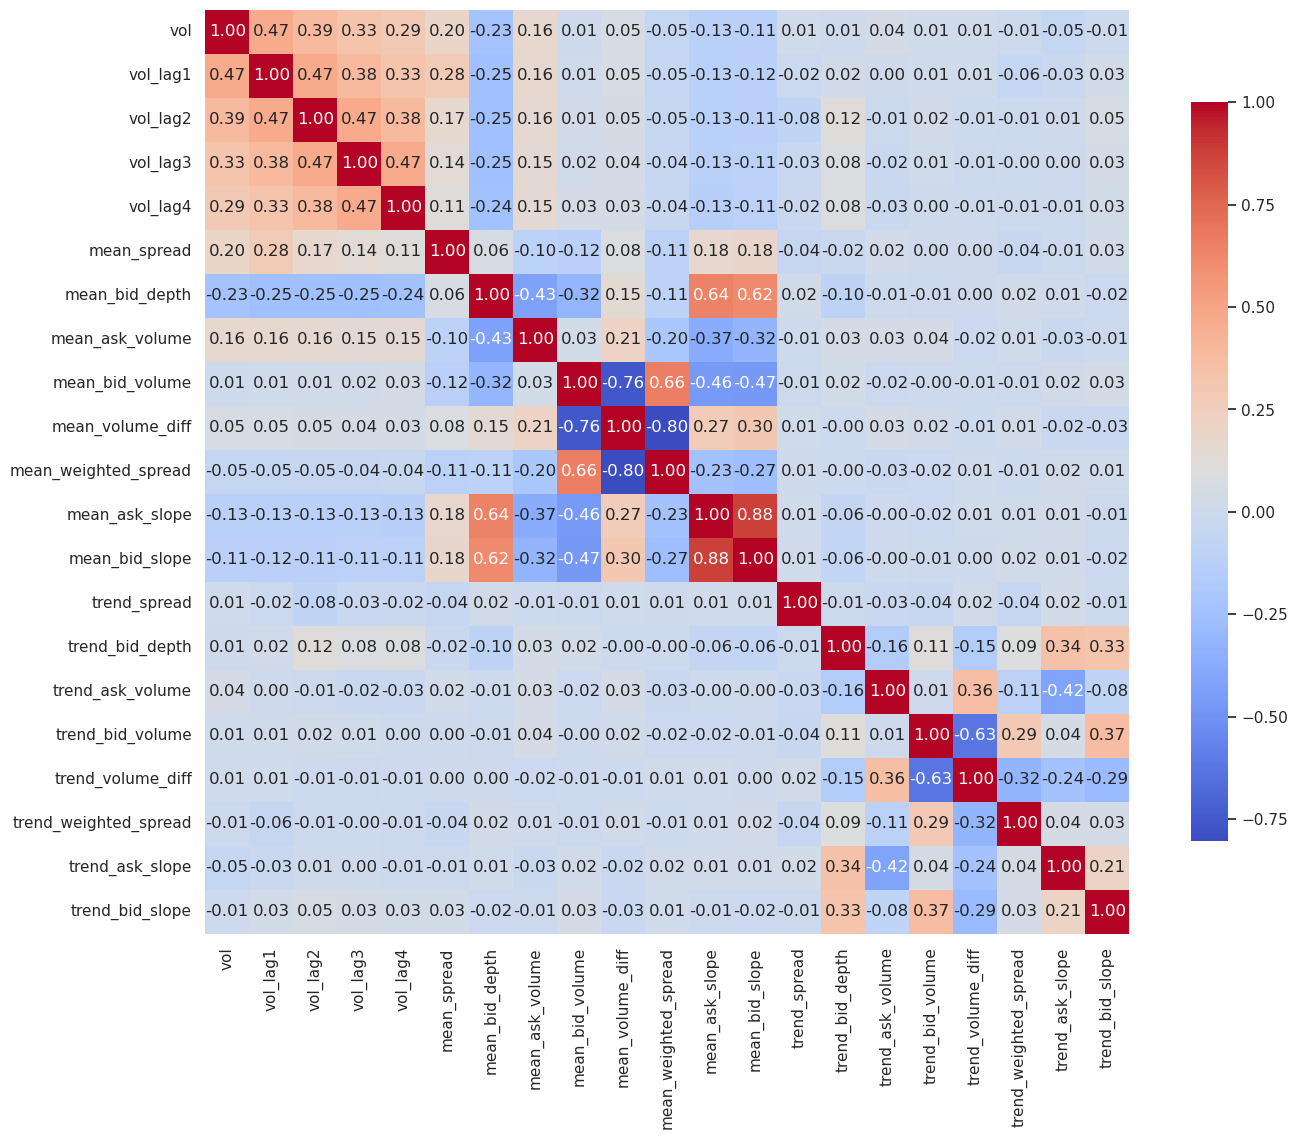

In [39]:
# compute kendall correlation
kendall_corr = init_training_vola.corr(method='kendall')
plt.figure(figsize=(16, 12))
sns.heatmap(kendall_corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})

The following are features we will keep as exogenous variables in all benchmark models.

In [40]:
ob_features = [
'mean_spread',
'mean_bid_depth',
'mean_ask_volume', 
#'mean_bid_volume',
#'mean_volume_diff', 
#'mean_weighted_spread',
'mean_ask_slope',
'mean_bid_slope']

Since no `trend` variables are used, there is no need for winsorization.

In [41]:
# LAST_TRAINING_DATE = datetime.strptime("2018-06-30 23:59:59", "%Y-%m-%d %H:%M:%S")
# initial_training_vola = full_data.loc[:LAST_TRAINING_DATE]
# initial_training_vola.to_csv(data_path / "btc" / "initial_training_data.csv", index=True)

# first_test_datetime = full_data.loc[LAST_TRAINING_DATE:].index[1]

# full_data.index[0] 

# # every monday after the last training date
# refit_dates = [day for day in (pd.date_range(start=LAST_TRAINING_DATE, 
#                                              end=full_data.index[-1],
#                                              freq='D')
#                                     ) if day.strftime("%A") == "Monday"]
# refit_dates += [refit_dates[-1] + pd.Timedelta(days=7)] # to include the last monday in the backtest
# test_timestamps = full_data.loc[first_test_datetime:].index

# is_training_expanded = False

# lookback = pd.Timedelta(days=30) # 1 week lookback

# for i,t in enumerate(refit_dates):
#     df = full_data.loc[:t-pd.Timedelta(hours=1)]
#     df.to_csv(data_path / "btc" / f"training_data_expanding_{i}.csv", index=True)

#     df = full_data.loc[t-lookback:t-pd.Timedelta(hours=1)]
#     df.to_csv(data_path / "btc" / f"training_data_montly_{i}.csv", index=True)


In [42]:
# for i,t in enumerate(refit_dates):
#         df = full_data.loc[t:t+pd.Timedelta(days=7)-pd.Timedelta(hours=1)]
#         df.to_csv(data_path / "btc" / f"test_data_weeks_{i}.csv", index=True)


# Add trade volume to `data_df.csv`

In [ ]:
csv_files = list(raw_data_path.glob("bitstamp_trx*.zip"))

In [ ]:
dataframes = []

for csv_file in tqdm(csv_files, desc="Processing CSV files"):
    # load and format
    trx_sample = pd.read_csv(csv_file)

    # fix column names by removing spaces and quotes
    trx_sample.columns = [s.replace(" ", "").replace("'", "") for s in trx_sample.columns]

    # 'datetime' columns to datetime type
    # trx_sample["datetime"] = pd.to_datetime(trx_sample["datetime"])

    dataframes.append(trx_sample)

df = pd.concat(dataframes, ignore_index=True)
df["datetime"] = pd.to_datetime(df["datetime"])
# re,move timezone information if exists
df["datetime"] = df["datetime"].dt.tz_localize(None)
df = df.set_index("datetime")
df.sort_index()

Processing CSV files:   2%|▏         | 2/122 [00:00<00:07, 15.25it/s]

Processing CSV files: 100%|██████████| 122/122 [00:06<00:00, 17.58it/s]


timestamp    price         cost        id  \
datetime                                                             
2018-05-31 21:00:13  1527800413000  7538.34    75.383400  67405327   
2018-05-31 21:00:18  1527800418000  7533.92    35.761333  67405331   
2018-05-31 21:00:18  1527800418000  7535.44  2995.337400  67405330   
2018-05-31 21:00:18  1527800418000  7536.00     7.536000  67405329   
2018-05-31 21:00:18  1527800418000  7537.49   753.749000  67405328   
...                            ...      ...          ...       ...   
2018-09-30 21:59:37  1538344777000  6555.78   280.549950  75177318   
2018-09-30 21:59:37  1538344777000  6555.77  1216.049379  75177317   
2018-09-30 21:59:37  1538344777000  6555.76  1497.396225  75177316   
2018-09-30 21:59:37  1538344777000  6555.75  1349.606357  75177315   
2018-09-30 21:59:37  1538344777000  6555.74  1106.925030  75177314   

                                      fee            fee1  order    symbol  \
datetime                                                                     
2018-05-31 21:00:13   {'currency': u'USD'   'cost': None}   None   BTC/USD   
2018-05-31 21:00:18   {'currency': u'USD'   'cost': None}   None   BTC/USD   
2018-05-31 21:00:18   {'currency': u'USD'   'cost': None}   None   BTC/USD   
2018-05-31 21:00:18   {'currency': u'USD'   'cost': None}   None   BTC/USD   
2018-05-31 21:00:18   {'currency': u'USD'   'cost': None}   None   BTC/USD   
...                                   ...             ...    ...       ...   
2018-09-30 21:59:37   {'currency': u'USD'   'cost': None}   None   BTC/USD   
2018-09-30 21:59:37   {'currency': u'USD'   'cost': None}   None   BTC/USD   
2018-09-30 21:59:37   {'currency': u'USD'   'cost': None}   None   BTC/USD   
2018-09-30 21:59:37   {'currency': u'USD'   'cost': None}   None   BTC/USD   
2018-09-30 21:59:37   {'currency': u'USD'   'cost': None}   None   BTC/USD   

                       amount   type   side  
datetime                                     
2018-05-31 21:00:13  0.010000   None   sell  
2018-05-31 21:00:18  0.004747   None   sell  
2018-05-31 21:00:18  0.397500   None   sell  
2018-05-31 21:00:18  0.001000   None   sell  
2018-05-31 21:00:18  0.100000   None   sell  
...                       ...    ...    ...  
2018-09-30 21:59:37  0.042794   None    buy  
2018-09-30 21:59:37  0.185493   None    buy  
2018-09-30 21:59:37  0.228409   None    buy  
2018-09-30 21:59:37  0.205866   None    buy  
2018-09-30 21:59:37  0.168848   None    buy  

[2795142 rows x 11 columns]

In [ ]:
volume = df.amount.resample("1h", closed="left", label="right").sum()
volume


datetime
2018-05-31 22:00:00    220.366844
2018-05-31 23:00:00    705.114174
2018-06-01 00:00:00    215.164963
2018-06-01 01:00:00    297.304541
2018-06-01 02:00:00    112.115274
                          ...    
2018-09-30 18:00:00     26.923696
2018-09-30 19:00:00     49.165087
2018-09-30 20:00:00     96.964626
2018-09-30 21:00:00    290.726892
2018-09-30 22:00:00    108.867295
Freq: h, Name: amount, Length: 2929, dtype: float64

In [ ]:
data_df = pd.read_csv(data_path / "btc" / "data_df.csv")
data_df["datetime"] = pd.to_datetime(data_df["datetime"])
data_df = data_df.set_index("datetime")
data_df.sort_index(inplace=True)
data_df = data_df.merge(volume.rename("volume"), left_index=True, right_index=True, how="left")
data_df = data_df.sort_index()

In [ ]:
data_df

vol       ret   ret_t-1   ret_t-2   ret_t-3  \
datetime                                                                
2018-06-04 23:00:00  0.000143 -0.002229 -0.000807 -0.001664 -0.002068   
2018-06-05 00:00:00  0.000115  0.001552 -0.000217 -0.002412 -0.000731   
2018-06-05 01:00:00  0.000090 -0.001719  0.001004  0.000560  0.000503   
2018-06-05 02:00:00  0.000502 -0.010899  0.000669  0.000013 -0.000724   
2018-06-05 03:00:00  0.000146  0.000408  0.000473 -0.003603 -0.000386   
...                       ...       ...       ...       ...       ...   
2018-09-30 17:00:00  0.000025 -0.000451 -0.000860  0.002857  0.000204   
2018-09-30 18:00:00  0.000014  0.000298  0.000607 -0.000619 -0.000017   
2018-09-30 19:00:00  0.000024 -0.002138 -0.000023 -0.000018  0.001304   
2018-09-30 20:00:00  0.000089 -0.003682 -0.000012  0.000760 -0.000497   
2018-09-30 21:00:00  0.000034  0.000611 -0.003663 -0.000011  0.001097   

                      ret_t-4   ret_t-5   ret_t-6   ret_t-7   ret_t-8  ...  \
datetime                                                               ...   
2018-06-04 23:00:00  0.001077 -0.002260  0.000301  0.000990  0.000041  ...   
2018-06-05 00:00:00 -0.000816  0.000611  0.000842 -0.000742  0.001837  ...   
2018-06-05 01:00:00 -0.000766 -0.000041 -0.000289 -0.000918  0.000120  ...   
2018-06-05 02:00:00  0.000081 -0.001212  0.001144 -0.000175 -0.000356  ...   
2018-06-05 03:00:00 -0.004847 -0.001068  0.000396  0.001105  0.000261  ...   
...                       ...       ...       ...       ...       ...  ...   
2018-09-30 17:00:00 -0.000439  0.000296  0.000723 -0.000709  0.000164  ...   
2018-09-30 18:00:00 -0.000020 -0.000150 -0.000742 -0.000193  0.000521  ...   
2018-09-30 19:00:00  0.000129  0.000396 -0.000298 -0.000406  0.000384  ...   
2018-09-30 20:00:00 -0.000854 -0.000152  0.000149 -0.002735  0.000052  ...   
2018-09-30 21:00:00 -0.003005  0.000823 -0.005300  0.004849  0.002053  ...   

                     ask_depth_t-120  bid_depth_t-120  depth_diff_t-120  \
datetime                                                                  
2018-06-04 23:00:00           4000.0           2809.0            1191.0   
2018-06-05 00:00:00           4000.0           2802.0            1198.0   
2018-06-05 01:00:00           4000.0           2817.0            1183.0   
2018-06-05 02:00:00           4000.0           2813.0            1187.0   
2018-06-05 03:00:00           4000.0           2772.0            1228.0   
...                              ...              ...               ...   
2018-09-30 17:00:00           4000.0           2841.0            1159.0   
2018-09-30 18:00:00           4000.0           2840.0            1160.0   
2018-09-30 19:00:00           4000.0           2841.0            1159.0   
2018-09-30 20:00:00           4000.0           2845.0            1155.0   
2018-09-30 21:00:00           4000.0           2839.0            1161.0   

                     ask_volume_t-120  bid_volume_t-120  volume_diff_t-120  \
datetime                                                                     
2018-06-04 23:00:00       2341.940396      12782.456607      -10440.516210   
2018-06-05 00:00:00       2362.768003      12699.117466      -10336.349463   
2018-06-05 01:00:00       2349.182465      12790.666762      -10441.484297   
2018-06-05 02:00:00       2356.082089      12731.928549      -10375.846459   
2018-06-05 03:00:00       2329.697927      12634.167822      -10304.469895   
...                               ...               ...                ...   
2018-09-30 17:00:00       2627.367204      11909.731066       -9282.363863   
2018-09-30 18:00:00       2614.198169      11899.085884       -9284.887715   
2018-09-30 19:00:00       2597.208539      11936.342886       -9339.134347   
2018-09-30 20:00:00       2607.346074      11983.235011       -9375.888938   
2018-09-30 21:00:00       2643.073340      11848.354147       -9205.280807   

                     weighted_spread_t-120  ask_slope_t-120  bid_slope

In [ ]:
data_df.to_csv(data_path / "btc" / "data_df_with_volume.csv")

# Make output templates

In [7]:
full_data = (
    pl.read_csv(data_path / "btc" / "data_df_with_volume.csv")
    .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
    .sort("datetime")
    ).to_pandas().set_index("datetime")
LAST_TRAINING_DATE = datetime.strptime("2018-06-30 23:59:59", "%Y-%m-%d %H:%M:%S")

In [8]:
test_data = full_data.loc[LAST_TRAINING_DATE:]

In [9]:
test_data

vol       ret   ret_t-1   ret_t-2   ret_t-3  \
datetime                                                                
2018-07-03 23:00:00  0.000285  0.004757  0.000070  0.000310 -0.000913   
2018-07-04 00:00:00  0.000241 -0.008128 -0.000990  0.002352  0.001386   
2018-07-04 01:00:00  0.000240  0.000449  0.000963 -0.000935 -0.001475   
2018-07-04 02:00:00  0.000173  0.000458 -0.002634  0.000704 -0.000730   
2018-07-04 03:00:00  0.000177  0.001280 -0.001011  0.001256 -0.000115   
...                       ...       ...       ...       ...       ...   
2018-09-30 17:00:00  0.000025 -0.000451 -0.000860  0.002857  0.000204   
2018-09-30 18:00:00  0.000014  0.000298  0.000607 -0.000619 -0.000017   
2018-09-30 19:00:00  0.000024 -0.002138 -0.000023 -0.000018  0.001304   
2018-09-30 20:00:00  0.000089 -0.003682 -0.000012  0.000760 -0.000497   
2018-09-30 21:00:00  0.000034  0.000611 -0.003663 -0.000011  0.001097   

                      ret_t-4   ret_t-5   ret_t-6   ret_t-7   ret_t-8  ...  \
datetime                                                               ...   
2018-07-03 23:00:00 -0.000027 -0.002540 -0.001752 -0.008606 -0.002550  ...   
2018-07-04 00:00:00 -0.000216  0.000018  0.000199 -0.000717  0.001636  ...   
2018-07-04 01:00:00 -0.002879  0.001830 -0.002742  0.000978 -0.000227  ...   
2018-07-04 02:00:00 -0.001463  0.000829  0.003289  0.000322  0.000285  ...   
2018-07-04 03:00:00  0.000712 -0.000528 -0.000147  0.000252 -0.001782  ...   
...                       ...       ...       ...       ...       ...  ...   
2018-09-30 17:00:00 -0.000439  0.000296  0.000723 -0.000709  0.000164  ...   
2018-09-30 18:00:00 -0.000020 -0.000150 -0.000742 -0.000193  0.000521  ...   
2018-09-30 19:00:00  0.000129  0.000396 -0.000298 -0.000406  0.000384  ...   
2018-09-30 20:00:00 -0.000854 -0.000152  0.000149 -0.002735  0.000052  ...   
2018-09-30 21:00:00 -0.003005  0.000823 -0.005300  0.004849  0.002053  ...   

                     ask_depth_t-120  bid_depth_t-120  depth_diff_t-120  \
datetime                                                                  
2018-07-03 23:00:00           4000.0           2654.0            1346.0   
2018-07-04 00:00:00           4000.0           2672.0            1328.0   
2018-07-04 01:00:00           4000.0           2650.0            1350.0   
2018-07-04 02:00:00           4000.0           2625.0            1375.0   
2018-07-04 03:00:00           4000.0           2624.0            1376.0   
...                              ...              ...               ...   
2018-09-30 17:00:00           4000.0           2841.0            1159.0   
2018-09-30 18:00:00           4000.0           2840.0            1160.0   
2018-09-30 19:00:00           4000.0           2841.0            1159.0   
2018-09-30 20:00:00           4000.0           2845.0            1155.0   
2018-09-30 21:00:00           4000.0           2839.0            1161.0   

                     ask_volume_t-120  bid_volume_t-120  volume_diff_t-120  \
datetime                                                                     
2018-07-03 23:00:00       2205.873365      14970.231950      -12764.358585   
2018-07-04 00:00:00       2181.357432      14990.464470      -12809.107038   
2018-07-04 01:00:00       2204.039464      14937.132604      -12733.093141   
2018-07-04 02:00:00       2217.612444      14842.550268      -12624.937823   
2018-07-04 03:00:00       2158.504284      14871.097858      -12712.593574   
...                               ...               ...                ...   
2018-09-30 17:00:00       2627.367204      11909.731066       -9282.363863   
2018-09-30 18:00:00       2614.198169      11899.085884       -9284.887715   
2018-09-30 19:00:00       2597.208539      11936.342886       -9339.134347   
2018-09-30 20:00:00       2607.346074      11983.235011       -9375.888938   
2018-09-30 21:00:00       2643.073340      11848.354147       -9205.280807   

                     weighted_spread_t-120  ask_slope_t-120  bid_slope

In [10]:
test_data.index

DatetimeIndex(['2018-07-03 23:00:00', '2018-07-04 00:00:00',
               '2018-07-04 01:00:00', '2018-07-04 02:00:00',
               '2018-07-04 03:00:00', '2018-07-04 04:00:00',
               '2018-07-04 05:00:00', '2018-07-04 06:00:00',
               '2018-07-04 07:00:00', '2018-07-04 08:00:00',
               ...
               '2018-09-30 12:00:00', '2018-09-30 13:00:00',
               '2018-09-30 14:00:00', '2018-09-30 15:00:00',
               '2018-09-30 16:00:00', '2018-09-30 17:00:00',
               '2018-09-30 18:00:00', '2018-09-30 19:00:00',
               '2018-09-30 20:00:00', '2018-09-30 21:00:00'],
              dtype='datetime64[us]', name='datetime', length=1958, freq=None)

In [11]:
output_template = pd.DataFrame(index=test_data.index, columns=["retraining_flag", "model_name"])

In [12]:
output_template.retraining_flag = False

In [13]:
output_template

retraining_flag model_name
datetime                                       
2018-07-03 23:00:00            False        NaN
2018-07-04 00:00:00            False        NaN
2018-07-04 01:00:00            False        NaN
2018-07-04 02:00:00            False        NaN
2018-07-04 03:00:00            False        NaN
...                              ...        ...
2018-09-30 17:00:00            False        NaN
2018-09-30 18:00:00            False        NaN
2018-09-30 19:00:00            False        NaN
2018-09-30 20:00:00            False        NaN
2018-09-30 21:00:00            False        NaN

[1958 rows x 2 columns]

In [14]:
refit_dates = pd.date_range(start=output_template.index[0],
                 end=output_template.index[-1]+ pd.Timedelta(days=5), # to include the last week
                 freq='5D')
refit_dates

DatetimeIndex(['2018-07-03 23:00:00', '2018-07-08 23:00:00',
               '2018-07-13 23:00:00', '2018-07-18 23:00:00',
               '2018-07-23 23:00:00', '2018-07-28 23:00:00',
               '2018-08-02 23:00:00', '2018-08-07 23:00:00',
               '2018-08-12 23:00:00', '2018-08-17 23:00:00',
               '2018-08-22 23:00:00', '2018-08-27 23:00:00',
               '2018-09-01 23:00:00', '2018-09-06 23:00:00',
               '2018-09-11 23:00:00', '2018-09-16 23:00:00',
               '2018-09-21 23:00:00', '2018-09-26 23:00:00',
               '2018-10-01 23:00:00'],
              dtype='datetime64[ns]', freq='5D')

In [15]:
dates = iter(refit_dates)

In [16]:
refit_dates = list(refit_dates)

prev = refit_dates[0] - pd.Timedelta(days=7)
next = refit_dates[0]
prev_writing = refit_dates[0]
for t in output_template.index:
    if prev < t and t >= next:
        prev = next
        next = refit_dates[refit_dates.index(next) + 1]
        output_template.loc[t, "retraining_flag"] = True
        print(f"Size of the window: {pd.Timedelta(t - prev_writing)}")
        prev_writing = t

Size of the window: 0 days 00:00:00
Size of the window: 5 days 00:00:00
Size of the window: 5 days 00:00:00
Size of the window: 5 days 00:00:00
Size of the window: 5 days 00:00:00
Size of the window: 5 days 00:00:00
Size of the window: 6 days 00:00:00
Size of the window: 4 days 00:00:00
Size of the window: 5 days 00:00:00
Size of the window: 5 days 00:00:00
Size of the window: 5 days 00:00:00
Size of the window: 5 days 00:00:00
Size of the window: 7 days 00:00:00
Size of the window: 3 days 00:00:00
Size of the window: 5 days 00:00:00
Size of the window: 5 days 00:00:00
Size of the window: 5 days 00:00:00
Size of the window: 5 days 00:00:00


In [17]:
output_template.loc[output_template.loc[:, "retraining_flag"] == True].head(20)

retraining_flag model_name
datetime                                       
2018-07-03 23:00:00             True        NaN
2018-07-08 23:00:00             True        NaN
2018-07-13 23:00:00             True        NaN
2018-07-18 23:00:00             True        NaN
2018-07-23 23:00:00             True        NaN
2018-07-28 23:00:00             True        NaN
2018-08-03 23:00:00             True        NaN
2018-08-07 23:00:00             True        NaN
2018-08-12 23:00:00             True        NaN
2018-08-17 23:00:00             True        NaN
2018-08-22 23:00:00             True        NaN
2018-08-27 23:00:00             True        NaN
2018-09-03 23:00:00             True        NaN
2018-09-06 23:00:00             True        NaN
2018-09-11 23:00:00             True        NaN
2018-09-16 23:00:00             True        NaN
2018-09-21 23:00:00             True        NaN
2018-09-26 23:00:00             True        NaN

In [18]:
# save the output template
output_template.to_csv(data_path / "btc" / "output_template.csv", index=True)

In [19]:
loaded = pd.read_csv(data_path / "btc" / "output_template.csv", index_col=0)

In [21]:
output_template.index

DatetimeIndex(['2018-07-03 23:00:00', '2018-07-04 00:00:00',
               '2018-07-04 01:00:00', '2018-07-04 02:00:00',
               '2018-07-04 03:00:00', '2018-07-04 04:00:00',
               '2018-07-04 05:00:00', '2018-07-04 06:00:00',
               '2018-07-04 07:00:00', '2018-07-04 08:00:00',
               ...
               '2018-09-30 12:00:00', '2018-09-30 13:00:00',
               '2018-09-30 14:00:00', '2018-09-30 15:00:00',
               '2018-09-30 16:00:00', '2018-09-30 17:00:00',
               '2018-09-30 18:00:00', '2018-09-30 19:00:00',
               '2018-09-30 20:00:00', '2018-09-30 21:00:00'],
              dtype='datetime64[us]', name='datetime', length=1958, freq=None)